In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


In [3]:
df = pd.read_csv("SeoulBikeData.csv", encoding="latin1")

# df['Date'] = pd.to_datetime(df['Date'])
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

print(df.head())
print(df.info())


        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   
1     

In [4]:
df = pd.get_dummies(
    df,
    columns=['Seasons', 'Holiday', 'Functioning Day'],
    drop_first=True
)


In [5]:
X = df.drop(['Rented Bike Count', 'Date'], axis=1)
y = df['Rented Bike Count']


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf'),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
}


In [10]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    results[name] = {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        # "RMSE": mean_squared_error(y_test, preds, squared=False)
        "RMSE" : rmse

    }

results_df = pd.DataFrame(results).T
print("\nClassical Models Performance:\n")
print(results_df)



Classical Models Performance:

                         R2         MAE        RMSE
Linear Regression  0.533685  330.385218  440.781358
SVR                0.353638  344.101312  518.945470
Random Forest      0.859921  145.244886  241.584918
Gradient Boosting  0.832639  173.774410  264.065131
MLP                0.837560  163.935410  260.154072


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y.iloc[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len=24)

split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]


In [12]:
import torch
import torch.nn as nn
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2):
        super().__init__()

        self.embedding = nn.Linear(num_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)   # Global Average Pooling
        return self.fc(x)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimeSeriesTransformer(num_features=X_train_seq.shape[2]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train_t = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).to(device)
# y_train_t = torch.tensor(y_train_seq.values, dtype=torch.float32).to(device)

for epoch in range(30):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train_t).squeeze()
    loss = criterion(preds, y_train_t)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f}")


Epoch 01 | Loss: 905193.0000
Epoch 02 | Loss: 904251.6250
Epoch 03 | Loss: 903707.6250
Epoch 04 | Loss: 903393.3750
Epoch 05 | Loss: 903177.5000
Epoch 06 | Loss: 902995.8125
Epoch 07 | Loss: 902814.0625
Epoch 08 | Loss: 902626.5000
Epoch 09 | Loss: 902441.0000
Epoch 10 | Loss: 902261.8750
Epoch 11 | Loss: 902082.3750
Epoch 12 | Loss: 901901.6250
Epoch 13 | Loss: 901714.2500
Epoch 14 | Loss: 901521.2500
Epoch 15 | Loss: 901323.0625
Epoch 16 | Loss: 901119.5625
Epoch 17 | Loss: 900908.5000
Epoch 18 | Loss: 900689.1875
Epoch 19 | Loss: 900460.5625
Epoch 20 | Loss: 900224.6250
Epoch 21 | Loss: 899980.3750
Epoch 22 | Loss: 899729.1875
Epoch 23 | Loss: 899468.9375
Epoch 24 | Loss: 899200.1250
Epoch 25 | Loss: 898922.3750
Epoch 26 | Loss: 898634.2500
Epoch 27 | Loss: 898335.9375
Epoch 28 | Loss: 898027.1875
Epoch 29 | Loss: 897708.3750
Epoch 30 | Loss: 897377.3750


In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

model.eval()
X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    preds = model(X_test_t).cpu().numpy().squeeze()

# 1) metrics on the SCALED sequence target
mse = mean_squared_error(y_test_seq, preds)
rmse = np.sqrt(mse)
print("\nTransformer Performance (scaled):")
print("R²:", r2_score(y_test_seq, preds))
print("MAE:", mean_absolute_error(y_test_seq, preds))
print("RMSE:", rmse)



Transformer Performance (scaled):
R²: -1.5077846050262451
MAE: 754.1963500976562
RMSE: 970.6865804676605


In [1]:
# ============================================================
# FULL PIPELINE: Classical Models + Transformer
# using your engineered SeoulBike features
# ============================================================

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn

# --------------------
# 1. Load + feature engineering (YOUR EXISTING CODE)
# --------------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [c for c in df.columns if c.startswith('Seasons_')]

# Chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# --------------------
# 2. Classical models on engineered features
# --------------------
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel="rbf"),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
}

print("\n=== Classical Models (engineered features) ===")
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    results[name] = {
        "R2": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": rmse,
    }

print(pd.DataFrame(results).T)

# --------------------
# 3. Sequence creation for Transformer
# --------------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i : i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

X_all_scaled = np.concatenate([X_train_scaled, X_test_scaled], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

X_seq, y_seq = create_sequences(X_all_scaled, y_all, seq_len=24)

split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

# --------------------
# 4. Transformer model
# --------------------
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(num_features, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.embedding(x)      # [B, T, d_model]
        x = self.transformer(x)    # [B, T, d_model]
        x = x.mean(dim=1)          # [B, d_model]
        return self.fc(x)          # [B, 1]

# --------------------
# 5. Train Transformer
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimeSeriesTransformer(num_features=X_train_seq.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_t = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).to(device)

print("\n=== Training Transformer (engineered features) ===")
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_t).squeeze()
    loss = criterion(preds, y_train_t)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f}")

# --------------------
# 6. Evaluate Transformer
# --------------------
model.eval()
X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
with torch.no_grad():
    transformer_preds = model(X_test_t).cpu().numpy().squeeze()

mse_tr = mean_squared_error(y_test_seq, transformer_preds)
rmse_tr = np.sqrt(mse_tr)

print("\n=== Transformer Results (engineered features) ===")
print("R2:", r2_score(y_test_seq, transformer_preds))
print("MAE:", mean_absolute_error(y_test_seq, transformer_preds))
print("RMSE:", rmse_tr)



=== Classical Models (engineered features) ===


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


                         R2         MAE        RMSE
Linear Regression  0.831371  160.000504  251.861910
SVR                0.273400  389.979321  522.809580
Random Forest      0.956136   78.474307  128.454054
Gradient Boosting  0.942706   97.085803  146.808070
MLP                0.944516   94.737785  144.470531

=== Training Transformer (engineered features) ===
Epoch 01 | Loss: 905391.0625
Epoch 02 | Loss: 904484.3750
Epoch 03 | Loss: 903903.5625
Epoch 04 | Loss: 903464.4375
Epoch 05 | Loss: 903152.8125
Epoch 06 | Loss: 902920.6250
Epoch 07 | Loss: 902731.3750
Epoch 08 | Loss: 902555.9375
Epoch 09 | Loss: 902373.1250
Epoch 10 | Loss: 902181.0000
Epoch 11 | Loss: 901974.1250
Epoch 12 | Loss: 901753.6875
Epoch 13 | Loss: 901525.3125
Epoch 14 | Loss: 901294.6250
Epoch 15 | Loss: 901062.8750
Epoch 16 | Loss: 900827.8125
Epoch 17 | Loss: 900587.8125
Epoch 18 | Loss: 900340.0625
Epoch 19 | Loss: 900084.6250
Epoch 20 | Loss: 899818.3750
Epoch 21 | Loss: 899543.5000
Epoch 22 | Loss: 899258.250

Random Forest is giving better accuracy

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Load and sort
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

# 2. Feature engineering (same logic as before)
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [c for c in df.columns if c.startswith('Seasons_')]

# 3. Chronological 80/20 split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# 4. Scaling (optional but consistent with your previous logic)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 5. Random Forest model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
rf_preds = rf.predict(X_test_scaled)

mse = mean_squared_error(y_test, rf_preds)
rmse = np.sqrt(mse)

print("\n=== Random Forest (engineered features) ===")
print(f"R2:   {r2_score(y_test, rf_preds):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, rf_preds):.4f}")
print(f"RMSE: {rmse:.4f}")



=== Random Forest (engineered features) ===
R2:   0.9561
MAE:  78.4743
RMSE: 128.4541


adding LSTM GRU components to it


Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

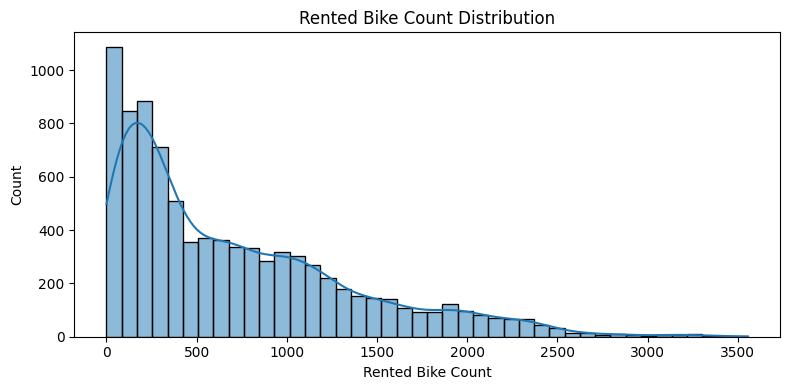

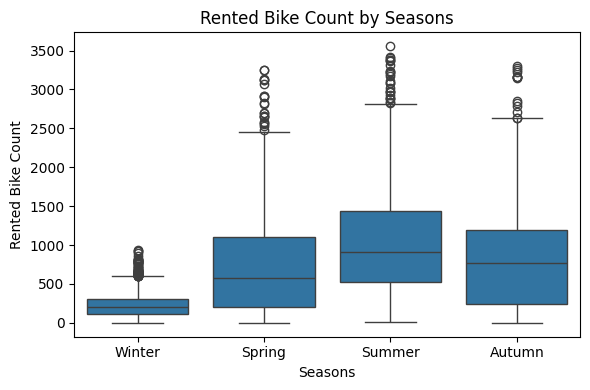

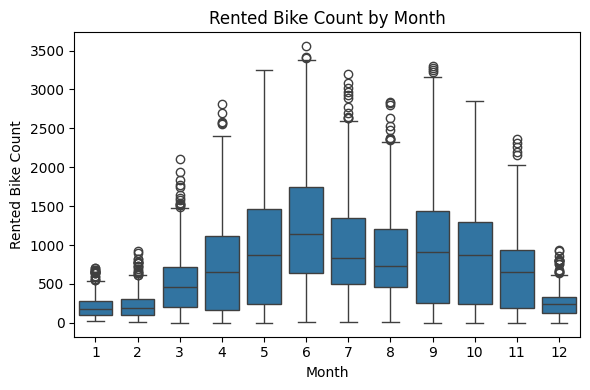

C:\Users\anavn\AppData\Local\Temp\ipykernel_14536\625706055.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


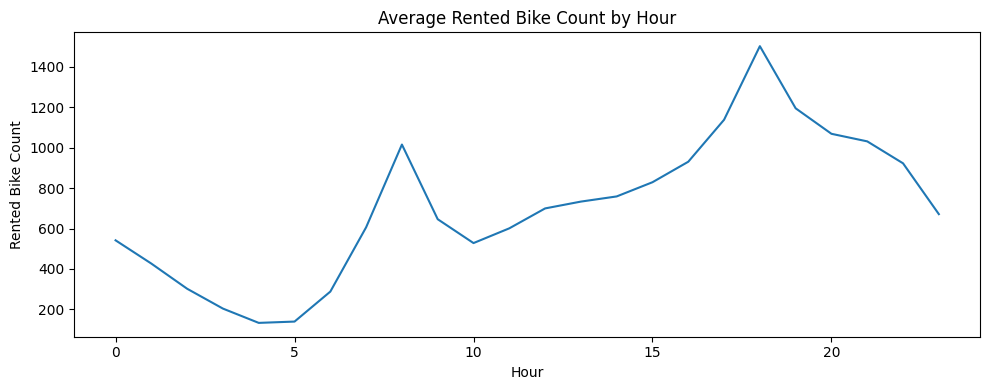

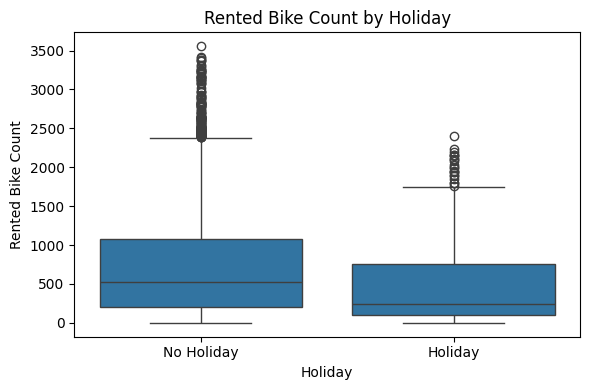

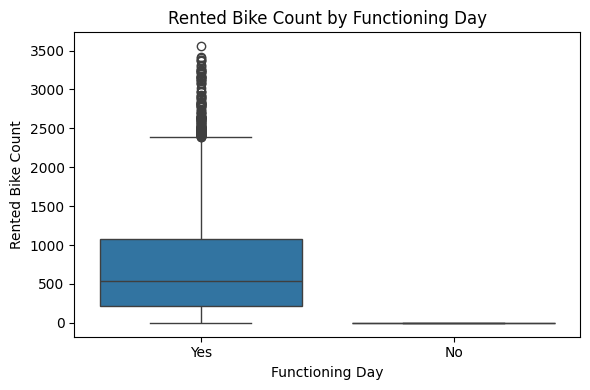

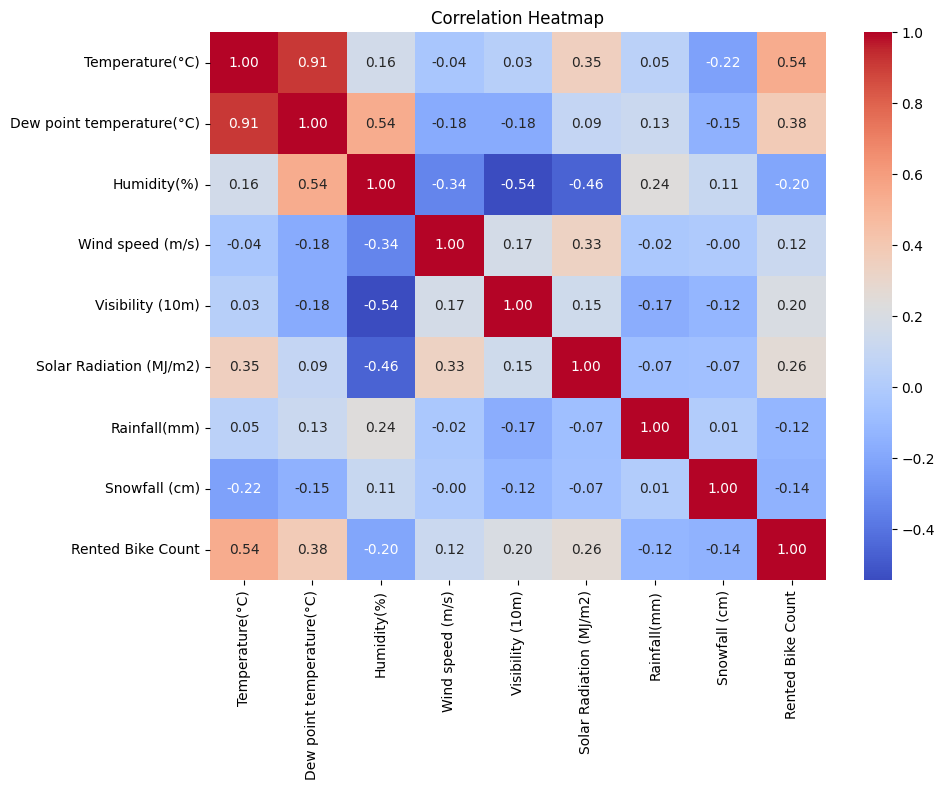

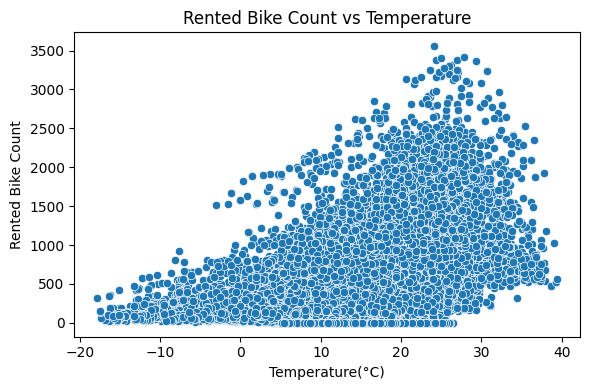

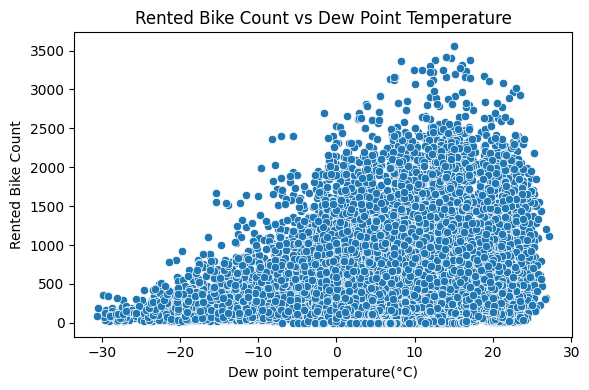

C:\Users\anavn\AppData\Local\Temp\ipykernel_14536\625706055.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


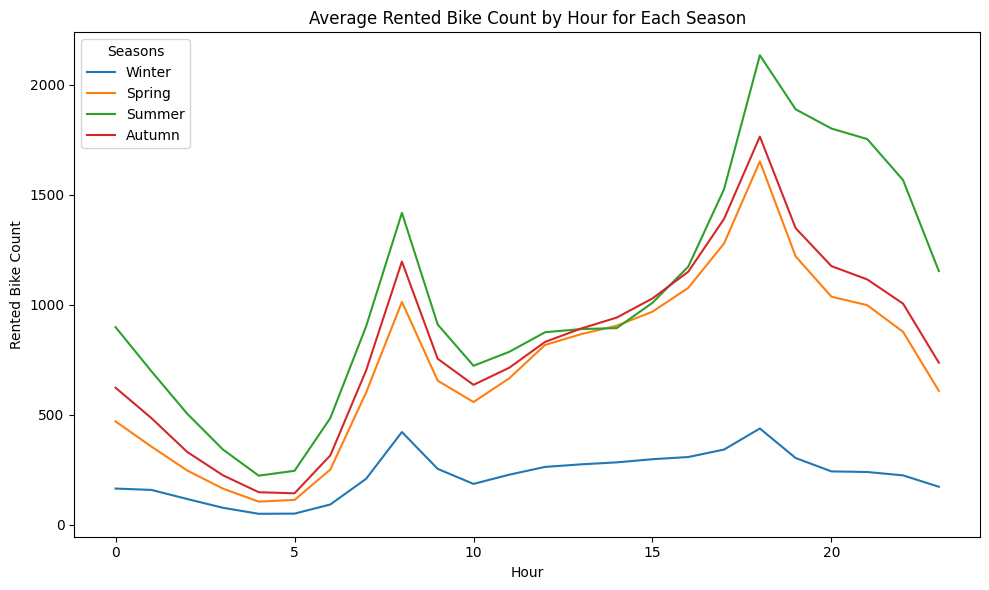


=== Random Forest Results ===
Train R2:   0.9958
Train RMSE: 42.2593
Test  R2:   0.9557
Test  RMSE: 129.0993
Test  MAE:  78.6678


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(



=== Training DeepLSTMGRUAttention ===
Epoch 1/100: Loss 0.5057
Epoch 2/100: Loss 0.1592
Epoch 3/100: Loss 0.1227
Epoch 4/100: Loss 0.1045
Epoch 5/100: Loss 0.0927
Epoch 6/100: Loss 0.0879
Epoch 7/100: Loss 0.0883
Epoch 8/100: Loss 0.0810
Epoch 9/100: Loss 0.0775
Epoch 10/100: Loss 0.0751
Epoch 11/100: Loss 0.0739
Epoch 12/100: Loss 0.0726
Epoch 13/100: Loss 0.0692
Epoch 14/100: Loss 0.0702
Epoch 15/100: Loss 0.0667
Epoch 16/100: Loss 0.0670
Epoch 17/100: Loss 0.0655
Epoch 18/100: Loss 0.0641
Epoch 19/100: Loss 0.0636
Epoch 20/100: Loss 0.0642
Epoch 21/100: Loss 0.0623
Epoch 22/100: Loss 0.0605
Epoch 23/100: Loss 0.0623
Epoch 24/100: Loss 0.0609
Epoch 25/100: Loss 0.0615
Epoch 26/100: Loss 0.0597
Epoch 27/100: Loss 0.0593
Epoch 28/100: Loss 0.0596
Epoch 29/100: Loss 0.0583
Epoch 30/100: Loss 0.0563
Epoch 31/100: Loss 0.0584
Epoch 32/100: Loss 0.0579
Epoch 33/100: Loss 0.0561
Epoch 34/100: Loss 0.0557
Epoch 35/100: Loss 0.0575
Epoch 36/100: Loss 0.0545
Epoch 37/100: Loss 0.0541
Epoch 38

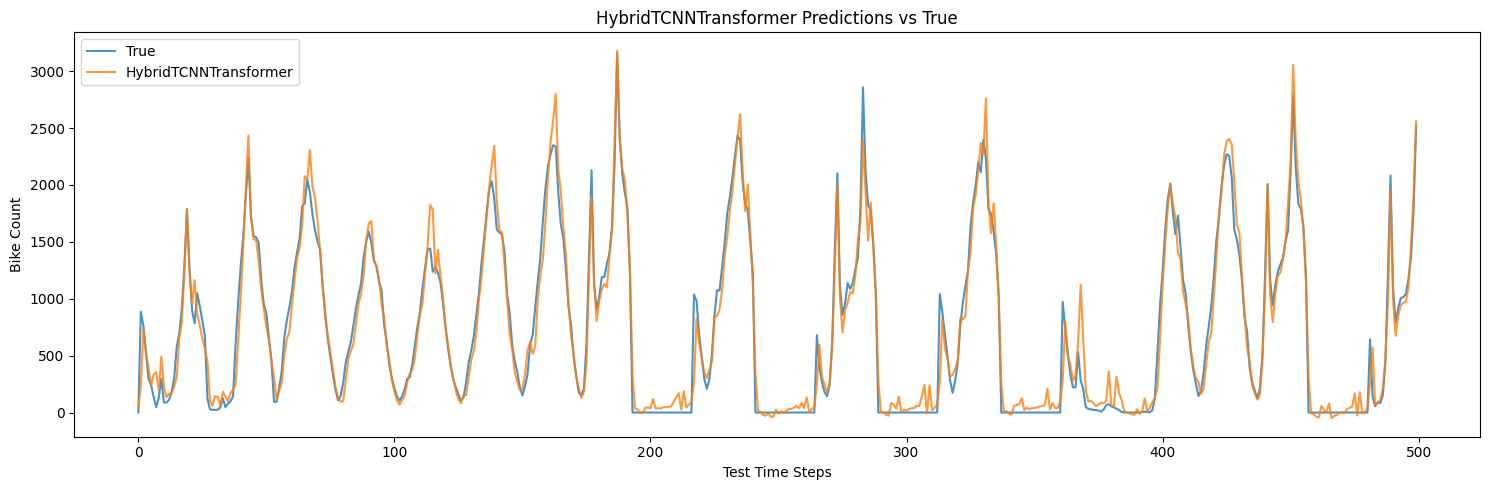

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

# ---------------- 2. EDA ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 6a. Random Forest on engineered features ----------------
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
rf_train_preds = rf.predict(X_train_scaled)
rf_test_preds = rf.predict(X_test_scaled)

rf_mse_tr = mean_squared_error(y_train, rf_train_preds)
rf_rmse_tr = np.sqrt(rf_mse_tr)
rf_mse_te = mean_squared_error(y_test, rf_test_preds)
rf_rmse_te = np.sqrt(rf_mse_te)

print("\n=== Random Forest Results ===")
print(f"Train R2:   {r2_score(y_train, rf_train_preds):.4f}")
print(f"Train RMSE: {rf_rmse_tr:.4f}")
print(f"Test  R2:   {r2_score(y_test, rf_test_preds):.4f}")
print(f"Test  RMSE: {rf_rmse_te:.4f}")
print(f"Test  MAE:  {mean_absolute_error(y_test, rf_test_preds):.4f}")

# ---------------- 6b. LSTM-GRU Attention on tabular data ----------------
X_train_tab = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_tab  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_t_tab = torch.from_numpy(X_train_tab)
y_train_t_tab = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_t_tab  = torch.from_numpy(X_test_tab)
y_test_t_tab  = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset_tab = TensorDataset(X_train_t_tab, y_train_t_tab)
test_dataset_tab  = TensorDataset(X_test_t_tab, y_test_t_tab)

train_loader_tab = DataLoader(train_dataset_tab, batch_size=32, shuffle=True)
test_loader_tab  = DataLoader(test_dataset_tab, batch_size=32)

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim,
                 lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128,
                 gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru   = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        return self.fc(attended)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = DeepLSTMGRUAttention(X_train_tab.shape[2], dropout=0.4).to(device)
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs_lstm = 100

print("\n=== Training DeepLSTMGRUAttention ===")
for epoch in range(epochs_lstm):
    lstm_model.train()
    train_losses = []
    for xb, yb in train_loader_tab:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_lstm.zero_grad()
        preds = lstm_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_lstm.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs_lstm}: Loss {np.mean(train_losses):.4f}")

lstm_model.eval()
y_true_all = []
y_pred_all = []
with torch.no_grad():
    for xb, yb in test_loader_tab:
        xb, yb = xb.to(device), yb.to(device)
        preds = lstm_model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse_l = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse_l = np.sqrt(mse_l)
mae_l = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx_l = y_true_all_orig > 10
mape_l = np.mean(
    np.abs((y_true_all_orig[safe_idx_l] - y_pred_all_orig[safe_idx_l]) /
           y_true_all_orig[safe_idx_l])
) * 100
smape_l = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== DeepLSTMGRUAttention TEST Results ===")
print(f"Test MSE:   {mse_l:.4f}")
print(f"Test RMSE:  {rmse_l:.4f}")
print(f"Test MAE:   {mae_l:.4f}")
print(f"Test MAPE:  {mape_l:.2f}%")
print(f"Test SMAPE: {smape_l:.2f}%")

# ---------------- 7. Sequence creation for HybridTCNNTransformer ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---- Positional encoding ----
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]

# ---- TemporalCNN branch ----
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        avg_pool = x.mean(dim=2)
        max_pool, _ = x.max(dim=2)
        feats = torch.cat([avg_pool, max_pool], dim=1)
        feats = self.dropout(feats)
        return feats

# ---- Hybrid: Transformer + TemporalCNN ----
class HybridTCNNTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.2,
        tcnn_channels=80
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.tcnn = TemporalCNN(input_size=input_size, channels=tcnn_channels, dropout=dropout)

        fusion_dim = d_model + 2 * tcnn_channels
        self.fc_out = nn.Linear(fusion_dim, 1)

    def forward(self, x):
        x_t = self.input_proj(x)
        x_t = self.pos_encoder(x_t)
        x_t = self.encoder(x_t)
        last_t = x_t[:, -1, :]

        tcnn_feats = self.tcnn(x)

        fused = torch.cat([last_t, tcnn_feats], dim=1)
        return self.fc_out(fused)

model = HybridTCNNTransformer(
    input_size=n_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.2,
    tcnn_channels=80
).to(device)

print(f"HybridTCNNTransformer: input {n_features} feats -> d_model=64, heads=4, layers=2, tcnn_channels=80")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

print("\n=== Training HybridTCNNTransformer ===")
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---- Evaluation: TRAIN ----
model.eval()
y_train_true_all = []
y_train_pred_all = []
with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())
y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== HybridTCNNTransformer TRAIN Results ===")
print(f"Train MSE:   {mse_tr:.4f}")
print(f"Train RMSE:  {rmse_tr:.4f}")
print(f"Train MAE:   {mae_tr:.4f}")
print(f"Train MAPE:  {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2:    {r2_tr:.4f}")

# ---- Evaluation: TEST ----
y_true_all = []
y_pred_all = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== HybridTCNNTransformer TEST Results ===")
print(f"Test MSE:   {mse:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test MAE:   {mae:.4f}")
print(f"Test MAPE:  {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2:    {r2:.4f}")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='HybridTCNNTransformer', alpha=0.8)
plt.legend()
plt.title('HybridTCNNTransformer Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ============================================================
# 1. Load and sort
# ============================================================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

# ============================================================
# 2. Feature engineering
# ============================================================
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# ============================================================
# 3. Feature columns
# ============================================================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [c for c in df.columns if c.startswith('Seasons_')]

# ============================================================
# 4. Chronological 80/20 split (no data leakage)
# ============================================================
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ============================================================
# 5. Scaling (for LSTM part; RF can also use scaled features)
# ============================================================
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# ============================================================
# 6. Sequence creation (same chronological split)
# ============================================================
SEQ_LEN = 24  # tune if you like

def create_sequences(X, y, seq_len):
    X_seqs, y_seqs = [], []
    for i in range(len(X) - seq_len + 1):
        X_seqs.append(X[i:i+seq_len])
        y_seqs.append(y[i+seq_len-1])
    return np.array(X_seqs, dtype=np.float32), np.array(y_seqs, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LEN)

# ============================================================
# 7. Dataset & DataLoader
# ============================================================
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 64
train_dataset = SeqDataset(X_train_seq, y_train_seq)
val_dataset   = SeqDataset(X_test_seq,  y_test_seq)   # test used as validation for early stopping

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

# ============================================================
# 8. Deep LSTM + GRU with attention (feature extractor)
# ============================================================
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128,
                 gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True,
                             dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True,
                             dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True,
                             dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True,
                          dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        # Important: expose feature size for RF
        self.feature_dim = gru_hidden

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)                 # (batch, seq_len, gru_hidden)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)  # (batch, gru_hidden)
        attended = self.dropout(attended)
        return attended                           # deep feature vector

# Simple head for training with MSE
class LSTMGRUHead(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.fc = nn.Linear(self.base.feature_dim, 1)

    def forward(self, x):
        features = self.base(x)
        out = self.fc(features).squeeze(-1)
        return out, features

input_dim = X_train_seq.shape[2]
base_model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
model = LSTMGRUHead(base_model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()

# ============================================================
# 9. Train LSTM+GRU with early stopping
# ============================================================
EPOCHS = 100
PATIENCE = 10
best_val_loss = np.inf
best_state = None
no_improve = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds, _ = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    print(f"Epoch {epoch:03d}/{EPOCHS} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ============================================================
# 10. Extract deep features for RF (hybrid architecture)
# ============================================================
def extract_features(model, loader, device):
    model.eval()
    feats = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            _, f = model(xb)               # (batch, feature_dim)
            feats.append(f.cpu().numpy())
            targets.append(yb.numpy())
    feats = np.concatenate(feats)
    targets = np.concatenate(targets)
    return feats, targets

train_loader_full = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader_full   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

train_feats, train_targets = extract_features(model, train_loader_full, device)
test_feats,  test_targets  = extract_features(model, val_loader_full,   device)

# Optionally concatenate original static features at sequence end index
# Align X_train/X_test with sequence targets (indices SEQ_LEN-1 ...)
X_train_tail = X_train_scaled[SEQ_LEN-1:]
X_test_tail  = X_test_scaled[SEQ_LEN-1:]

hybrid_X_train = np.concatenate([train_feats, X_train_tail], axis=1)
hybrid_X_test  = np.concatenate([test_feats,  X_test_tail],  axis=1)

# ============================================================
# 11. Random Forest on deep features + raw features
# ============================================================
rf_hybrid = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_hybrid.fit(hybrid_X_train, train_targets)
hybrid_preds = rf_hybrid.predict(hybrid_X_test)

mse_h = mean_squared_error(test_targets, hybrid_preds)
rmse_h = np.sqrt(mse_h)

print("\n=== Hybrid LSTM+GRU+RandomForest (single stacked architecture) ===")
print(f"R2:   {r2_score(test_targets, hybrid_preds):.4f}")
print(f"MAE:  {mean_absolute_error(test_targets, hybrid_preds):.4f}")
print(f"RMSE: {rmse_h:.4f}")


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 001/100 | Train: 906569.3199 | Val: 930813.0519
Epoch 002/100 | Train: 891146.2347 | Val: 928229.6261
Epoch 003/100 | Train: 886950.7106 | Val: 925901.8817
Epoch 004/100 | Train: 887044.1625 | Val: 923653.6602
Epoch 005/100 | Train: 884551.0771 | Val: 921445.7924
Epoch 006/100 | Train: 889845.5273 | Val: 919277.6786
Epoch 007/100 | Train: 880643.4259 | Val: 917108.1406
Epoch 008/100 | Train: 884925.4489 | Val: 914988.5943
Epoch 009/100 | Train: 879002.9330 | Val: 912881.6758
Epoch 010/100 | Train: 876548.9256 | Val: 910775.7561
Epoch 011/100 | Train: 874202.1699 | Val: 908677.6775
Epoch 012/100 | Train: 870791.0330 | Val: 906590.9821
Epoch 013/100 | Train: 876474.2807 | Val: 904521.6529
Epoch 014/100 | Train: 868386.0384 | Val: 902449.8610
Epoch 015/100 | Train: 870974.0162 | Val: 900394.3683
Epoch 016/100 | Train: 866358.0341 | Val: 898342.6116
Epoch 017/100 | Train: 863889.6284 | Val: 896300.9609
Epoch 018/100 | Train: 867551.2190 | Val: 894262.5614
Epoch 019/100 | Train: 87004

RF + TCNN

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

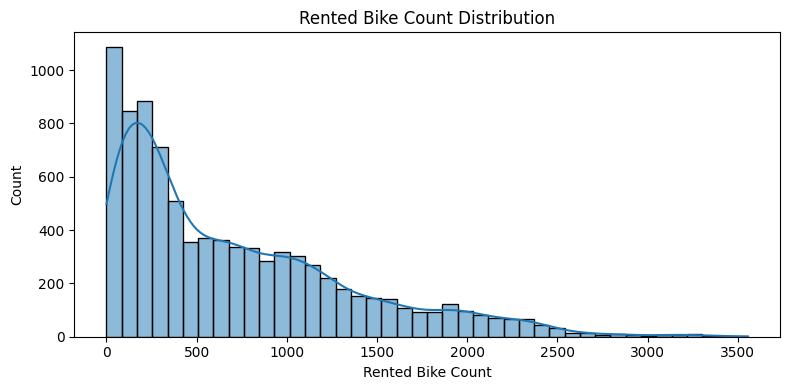

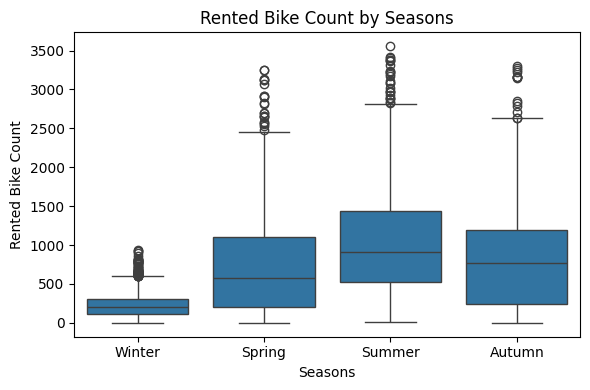

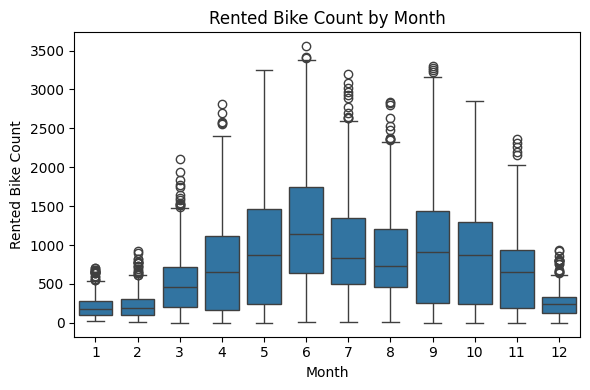

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\361237725.py:95: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


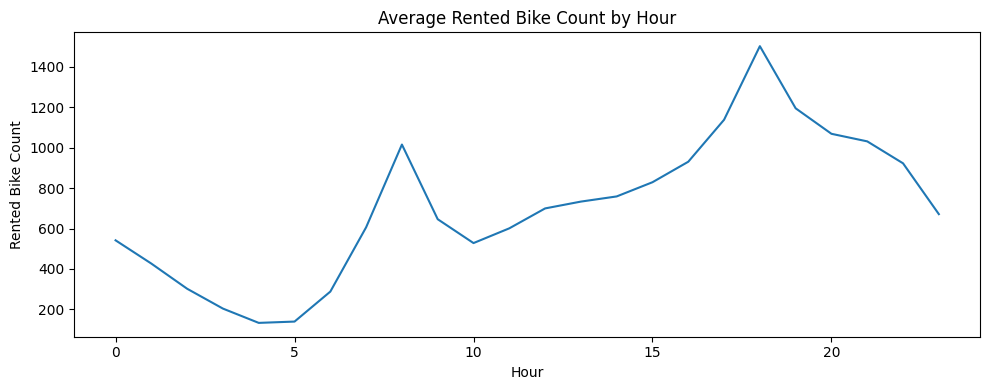

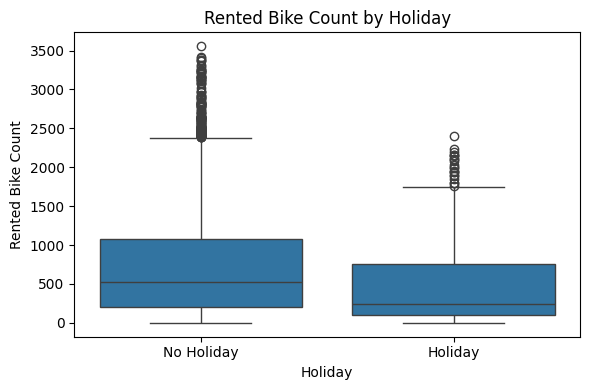

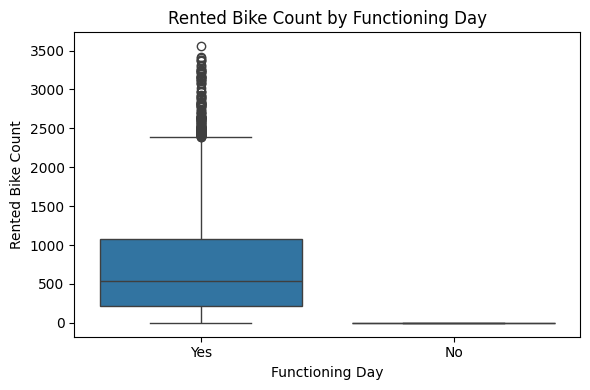

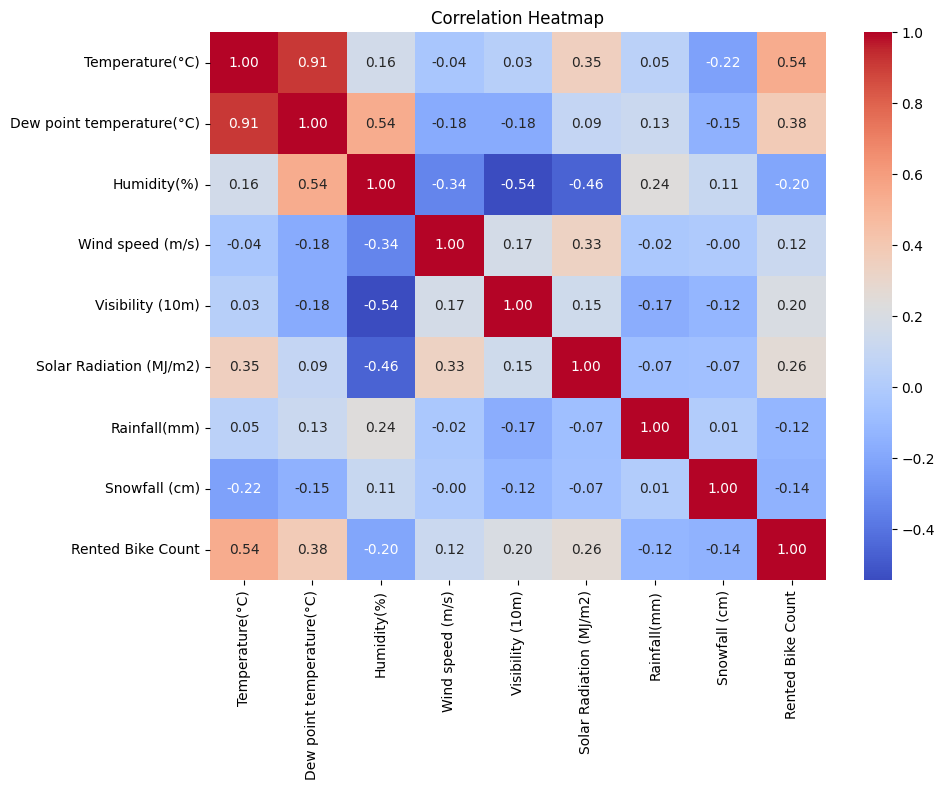

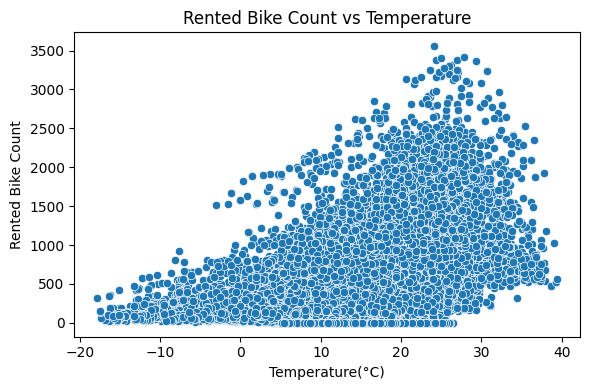

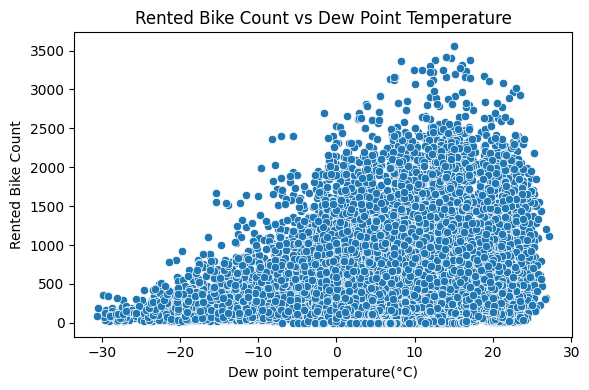

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\361237725.py:143: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


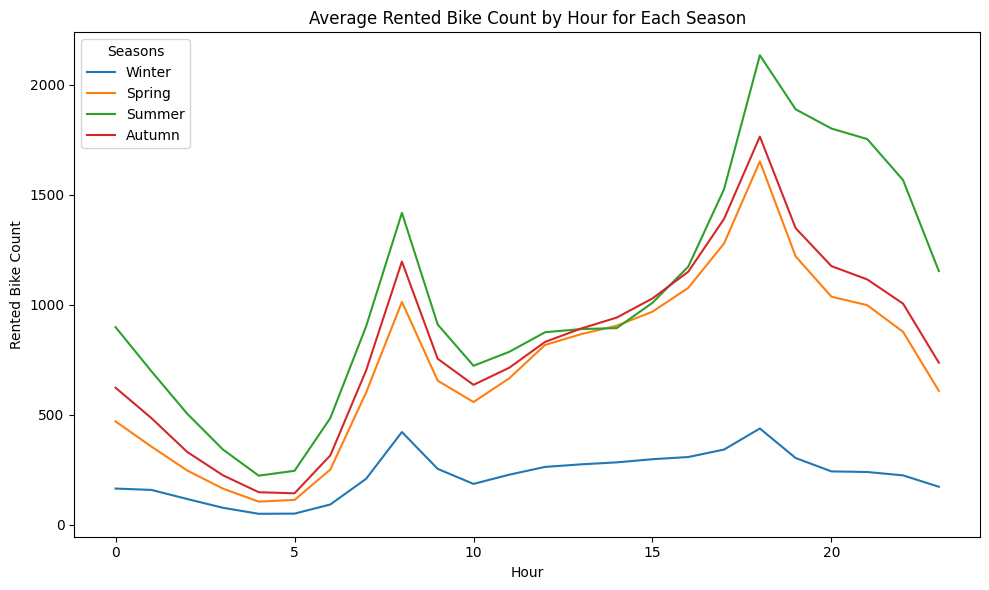

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
TemporalCNN: input 30 feats -> channels=80
Epoch 1/100: train 0.3896 | val 0.2535
Epoch 2/100: train 0.1723 | val 0.1863
Epoch 3/100: train 0.1397 | val 0.1341
Epoch 4/100: train 0.1179 | val 0.0834
Epoch 5/100: train 0.1072 | val 0.0993
Epoch 6/100: train 0.1026 | val 0.1005
Epoch 7/100: train 0.1059 | val 0.1029
Epoch 8/100: train 0.0979 | val 0.1008
Epoch 9/100: train 0.1029 | val 0.0749
Epoch 10/100: train 0.0911 | val 0.0623
Epoch 11/100: train 0.0922 | val 0.0626
Epoch 12/100: train 0.0846 | val 0.0710
Epoch 13/100: train 0.0832 | val 0.0779
Epoch 14/100: train 0.0777 | val 0.0555
Epoch 15/100: train 0.0738 | val 0.0843
Epoch 16/100: train 0.0746 | val 0.0686
Epoch 17/100: train 0.0700 | val 0.0729
Epoch 18/100: train 0.0707 | val 0.0527
Epoch 19/100: train 0.0637 | val 0.0538
Epoch 20/100: train 0.0671 | val 0.0875
Epoch 21/100: train 0.0723 | val 0.0550
Epoch 22/100: train 0.0611 |

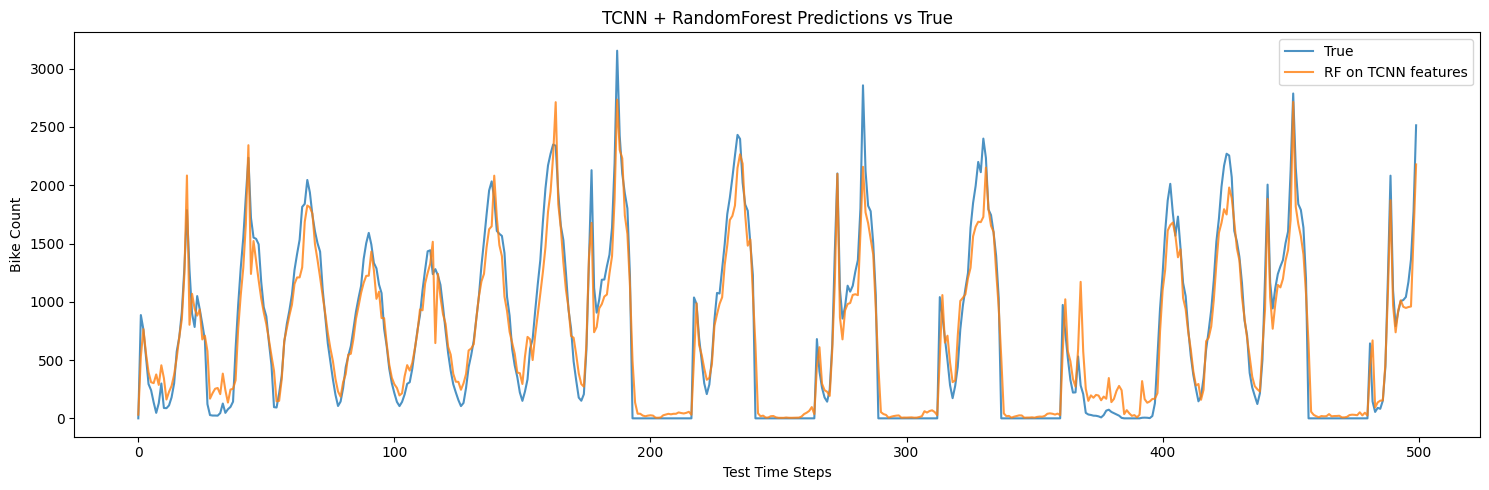

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device, is_wrapper=False):
    """
    model: either a nn.Module or a callable(x)->preds
    if is_wrapper=True, model is treated as a callable that returns preds.
    """
    if not is_wrapper:
        model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            if is_wrapper:
                preds = model(xb)        # callable
            else:
                preds, _ = model(xb)     # TCNNWithHead -> (preds, feats)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning: convert Date to datetime, sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (same as your script) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Chronological train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences (time-based, end part as val)
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. TemporalCNN as feature extractor ----------------
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.channels = channels

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)          # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)              # [B, C, T]

        avg_pool = x.mean(dim=2)       # [B, C]
        max_pool, _ = x.max(dim=2)     # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]
        feats = self.dropout(feats)
        return feats                   # [B, 2C]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tcnn_channels = 80
feature_extractor = TemporalCNN(
    input_size=n_features,
    channels=tcnn_channels,
    dropout=0.3
).to(device)

print(f"TemporalCNN: input {n_features} feats -> channels={tcnn_channels}")

# ---------------- 9. TCNN + small head (for feature training) ----------------
class TCNNWithHead(nn.Module):
    def __init__(self, base, channels):
        super().__init__()
        self.base = base
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        feats = self.base(x)          # [B, 2C]
        out = self.fc(feats)          # [B, 1]
        return out, feats

model = TCNNWithHead(feature_extractor, tcnn_channels).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 10. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    # Now pass the model directly, no lambda
    val_loss = evaluate_loss(model, val_loader, criterion, device, is_wrapper=False)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break


# ---------------- 11. Extract deep features for RF ----------------
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            _, feats = model(xb)          # [B, 2C]
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)      # [N, 2C]
    all_targets = np.concatenate(all_targets, axis=0)  # [N, 1]
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats,  test_targets_scaled  = extract_features(model, test_loader_full,  device)

# Inverse-scale targets back to original scale
train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets  = scaler_y.inverse_transform(test_targets_scaled)

# ---------------- 12. RandomForest on TCNN features ----------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# ---------------- 13. Evaluation on TEST set (original scale) ----------------
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== TCNN features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 14. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on TCNN features', alpha=0.8)
plt.legend()
plt.title('TCNN + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


RF and LSTM

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

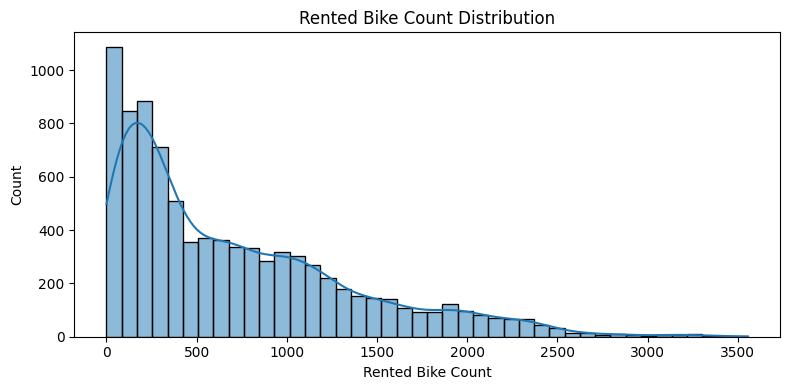

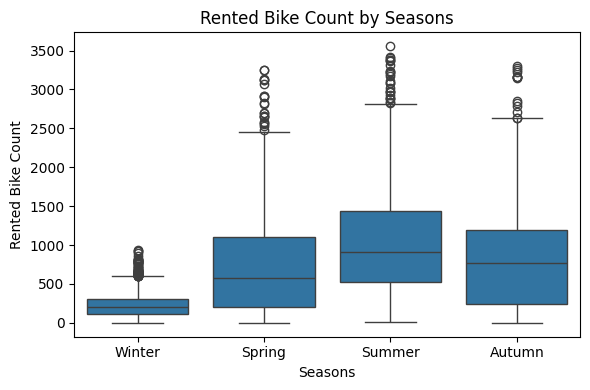

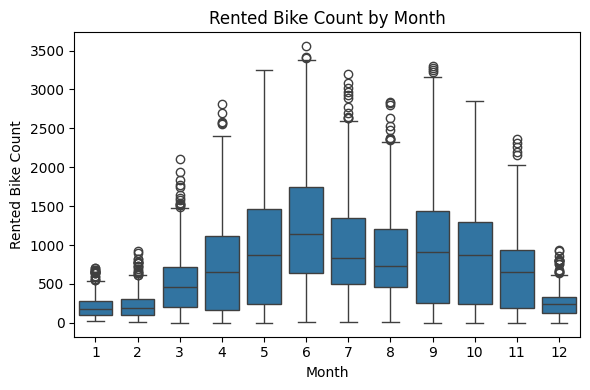

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\3015193702.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


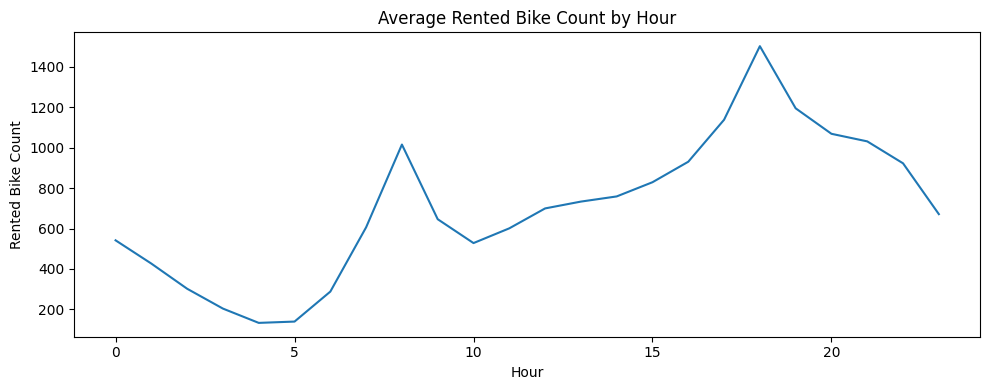

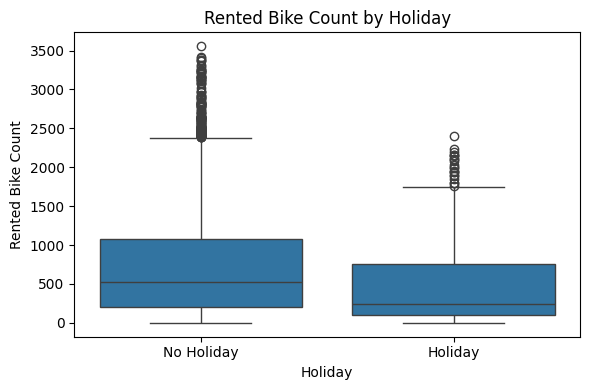

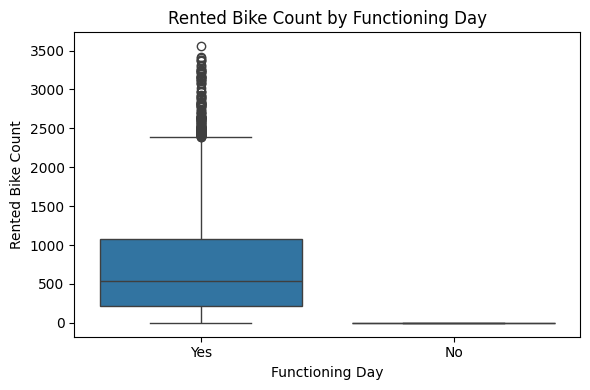

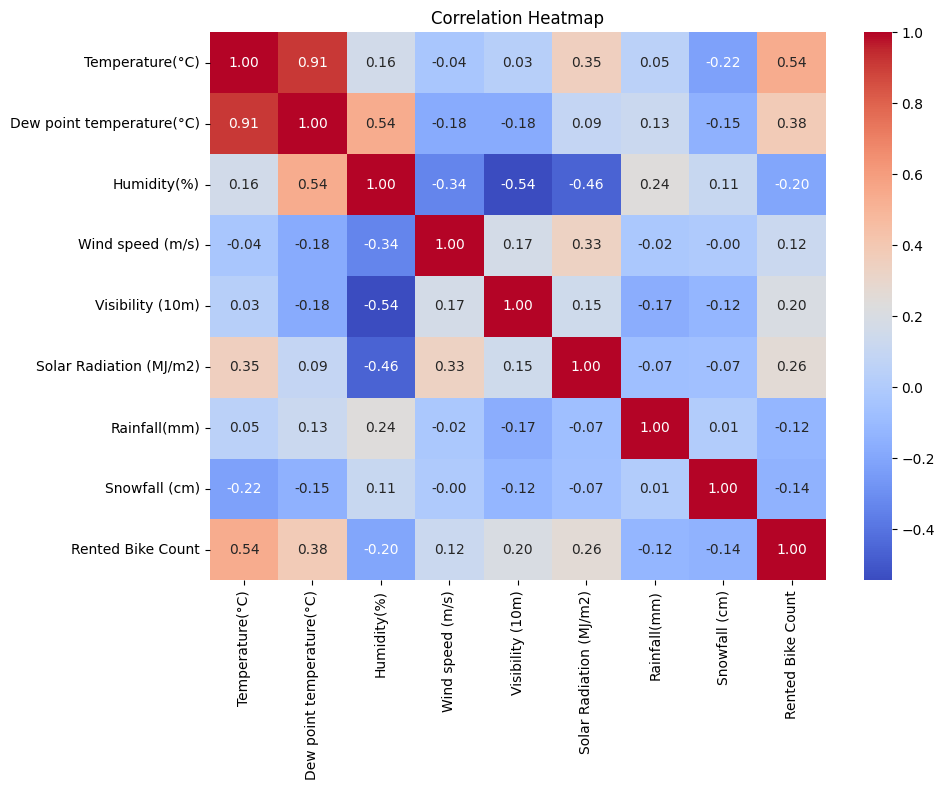

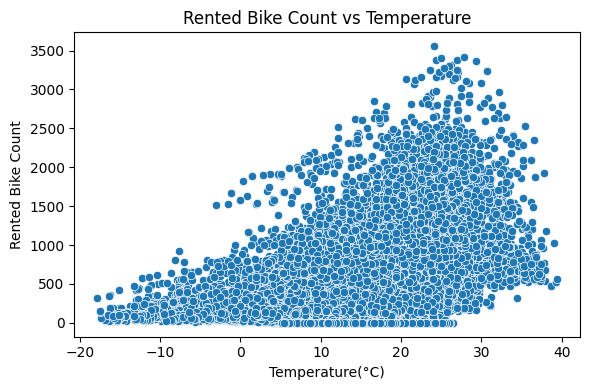

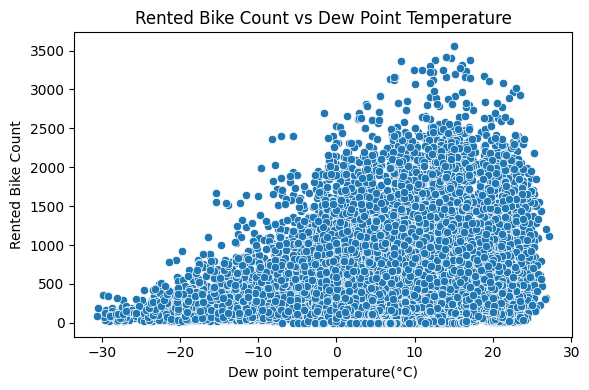

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\3015193702.py:133: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


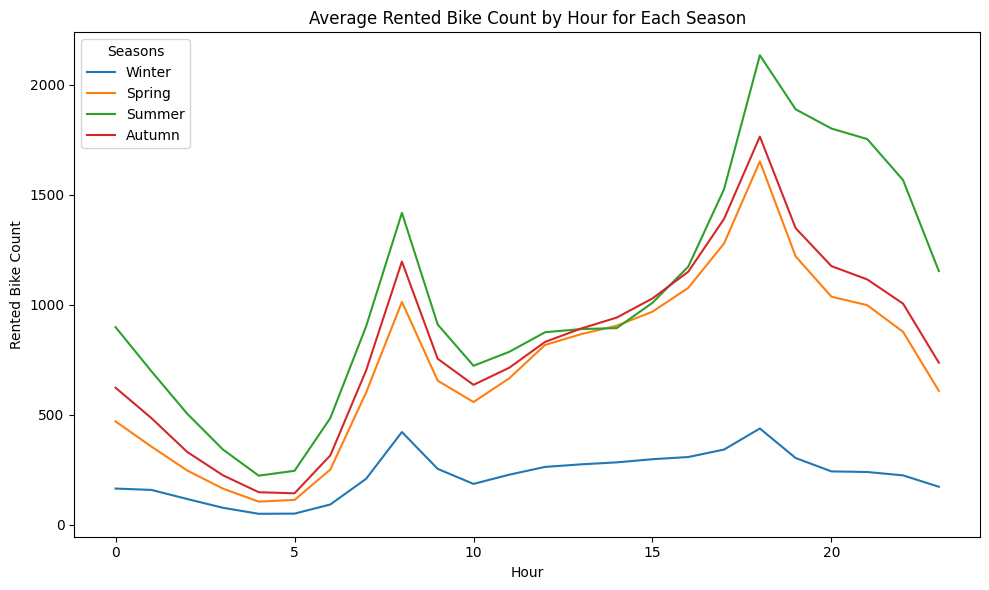

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
Model input_dim: 30


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: train 0.5153 | val 0.6279
Epoch 2/100: train 0.3021 | val 0.5646
Epoch 3/100: train 0.2648 | val 0.6226
Epoch 4/100: train 0.2439 | val 0.6063
Epoch 5/100: train 0.2135 | val 0.4790
Epoch 6/100: train 0.2015 | val 0.4516
Epoch 7/100: train 0.1927 | val 0.3752
Epoch 8/100: train 0.1747 | val 0.3651
Epoch 9/100: train 0.1676 | val 0.3203
Epoch 10/100: train 0.1575 | val 0.3214
Epoch 11/100: train 0.1451 | val 0.4197
Epoch 12/100: train 0.1316 | val 0.3762
Epoch 13/100: train 0.1171 | val 0.3737
Epoch 14/100: train 0.1173 | val 0.3008
Epoch 15/100: train 0.1091 | val 0.3242
Epoch 16/100: train 0.1011 | val 0.3029
Epoch 17/100: train 0.0932 | val 0.3426
Epoch 18/100: train 0.0928 | val 0.2700
Epoch 19/100: train 0.0850 | val 0.3299
Epoch 20/100: train 0.0822 | val 0.2871
Epoch 21/100: train 0.0805 | val 0.3488
Epoch 22/100: train 0.0758 | val 0.2881
Epoch 23/100: train 0.0743 | val 0.3410
Epoch 24/100: train 0.0708 | val 0.2785
Epoch 25/100: train 0.0699 | val 0.2653
Epoch 26/

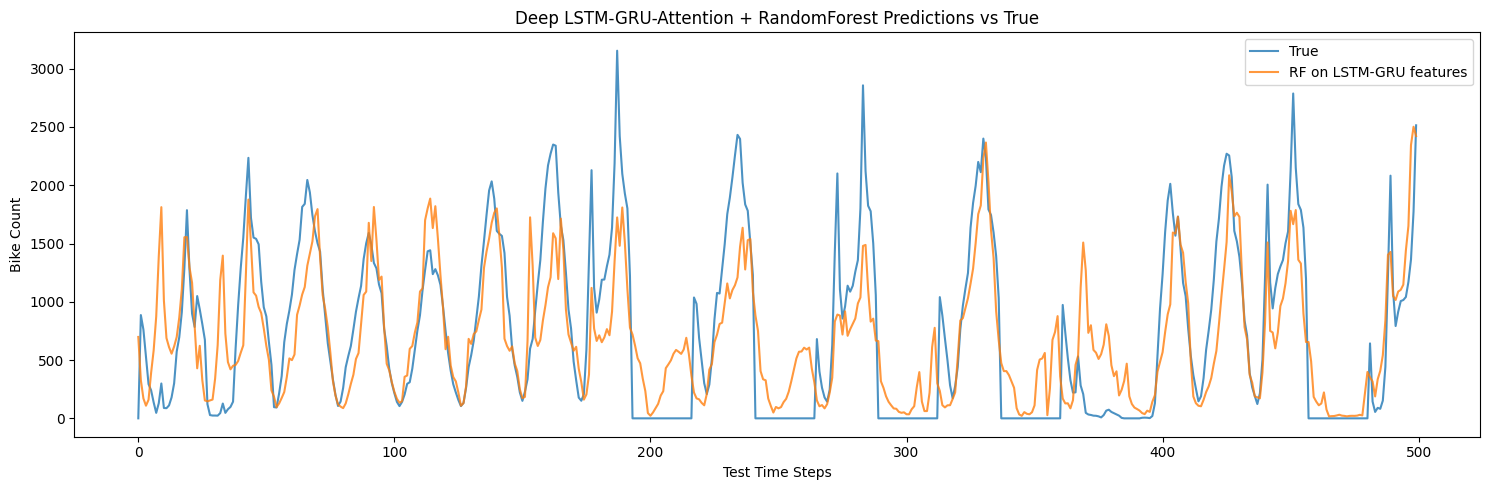

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning: convert Date to datetime, sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (same as your script) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Chronological train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences (time-based, end part as val)
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. Deep LSTM-GRU Attention Model ----------------
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# FIXED: Use sequence data shape instead of 2D data
input_dim = n_features  # X_train_seq.shape[2]
model = DeepLSTMGRUAttention(input_dim=input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model input_dim: {input_dim}")

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Extract deep features for RF ----------------
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            # Use last hidden state as features for RF
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            out, _ = model.gru(out)
            feats = out[:, -1, :]  # Last timestep features [B, gru_hidden]
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

# Inverse-scale targets back to original scale
train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# ---------------- 11. RandomForest on LSTM features ----------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# ---------------- 12. Evaluation on TEST set (original scale) ----------------
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== LSTM-GRU-Attention features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 13. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on LSTM-GRU features', alpha=0.8)
plt.legend()
plt.title('Deep LSTM-GRU-Attention + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


simple LSTM

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

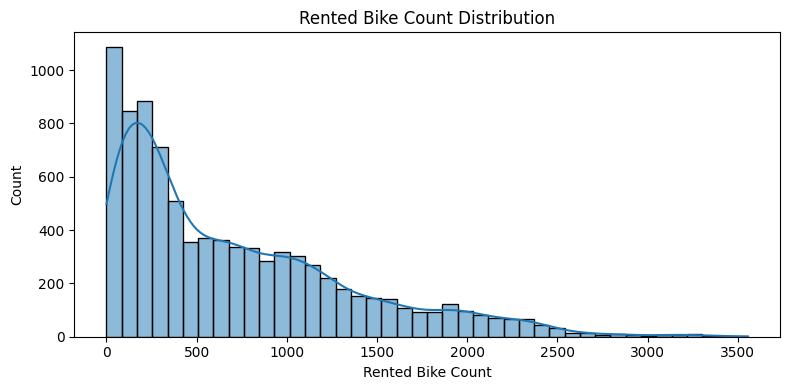

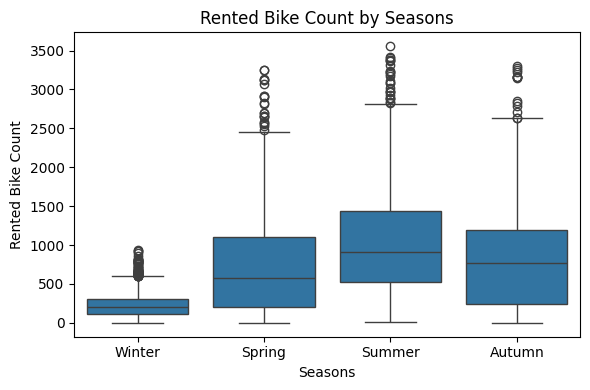

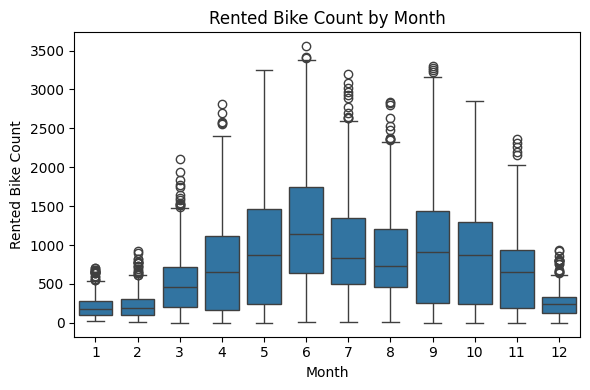

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\2172430543.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


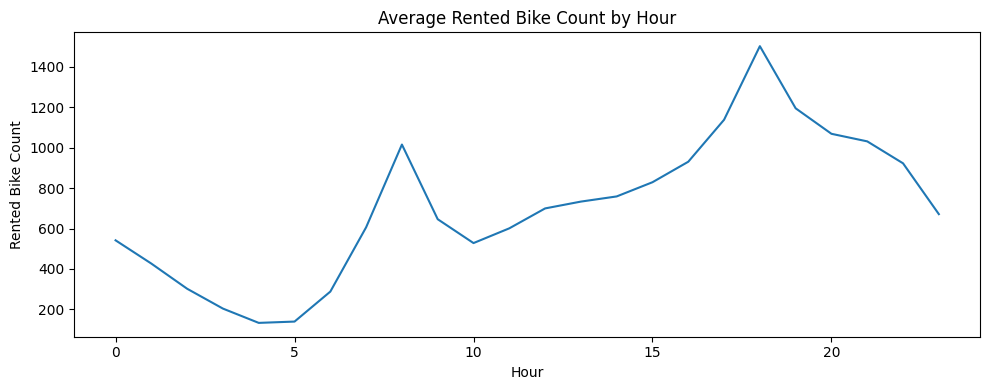

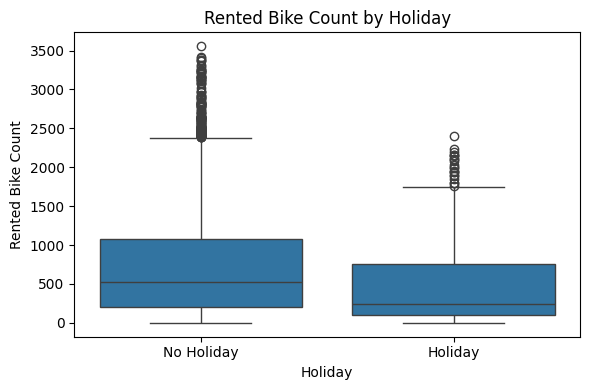

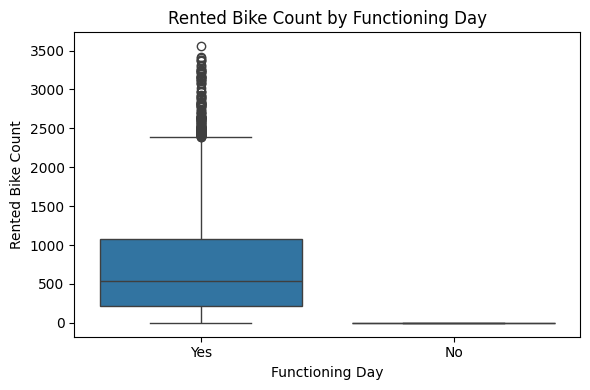

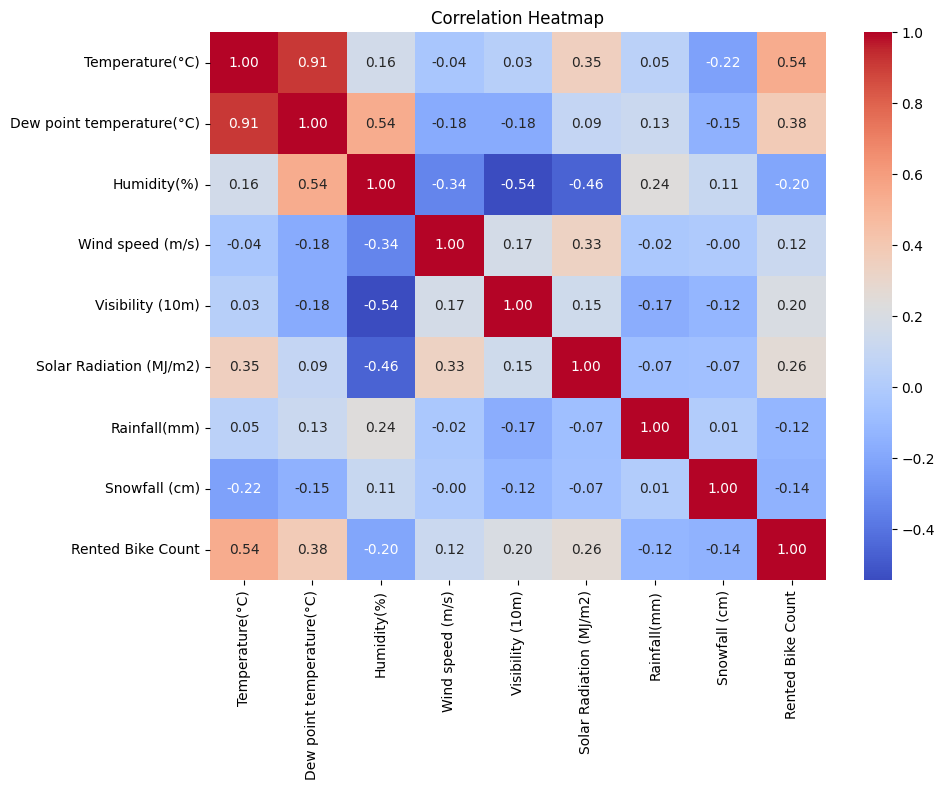

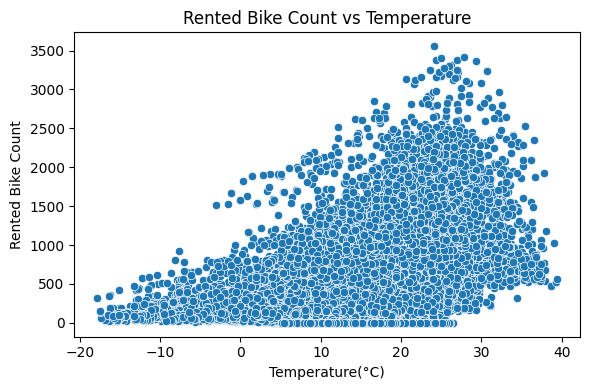

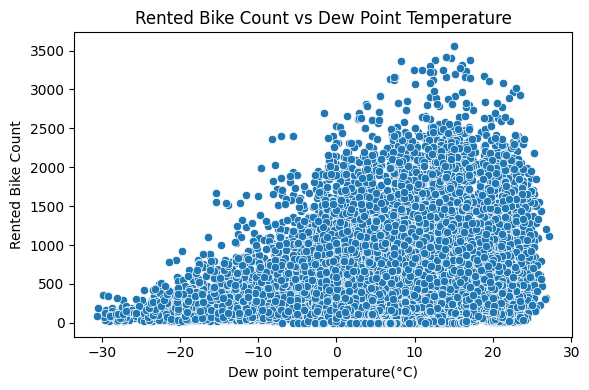

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\2172430543.py:133: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


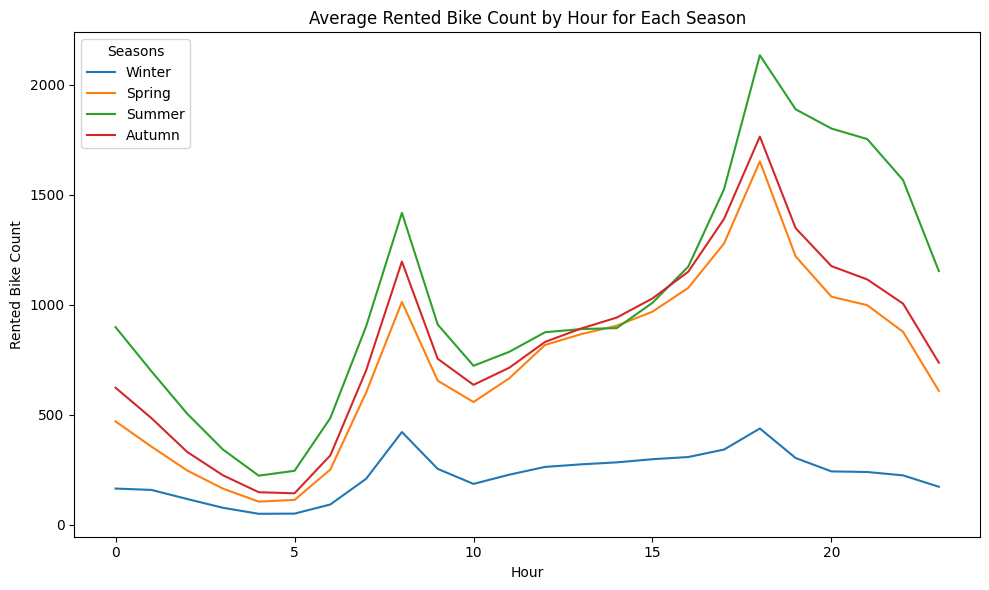

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
Simple Deep LSTM: input_dim=30, hidden=[256,128,64]


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/100: train 0.3843 | val 0.3970
Epoch 2/100: train 0.2010 | val 0.3000
Epoch 3/100: train 0.1488 | val 0.2057
Epoch 4/100: train 0.1232 | val 0.1894
Epoch 5/100: train 0.1064 | val 0.1815
Epoch 6/100: train 0.0936 | val 0.1722
Epoch 7/100: train 0.0833 | val 0.1333
Epoch 8/100: train 0.0699 | val 0.1310
Epoch 9/100: train 0.0637 | val 0.1249
Epoch 10/100: train 0.0592 | val 0.1024
Epoch 11/100: train 0.0502 | val 0.0920
Epoch 12/100: train 0.0453 | val 0.0995
Epoch 13/100: train 0.0422 | val 0.0795
Epoch 14/100: train 0.0398 | val 0.0932
Epoch 15/100: train 0.0423 | val 0.0777
Epoch 16/100: train 0.0358 | val 0.0891
Epoch 17/100: train 0.0350 | val 0.0724
Epoch 18/100: train 0.0331 | val 0.0843
Epoch 19/100: train 0.0325 | val 0.0739
Epoch 20/100: train 0.0332 | val 0.0660
Epoch 21/100: train 0.0328 | val 0.0629
Epoch 22/100: train 0.0308 | val 0.0625
Epoch 23/100: train 0.0279 | val 0.0658
Epoch 24/100: train 0.0280 | val 0.0603
Epoch 25/100: train 0.0284 | val 0.0695
Epoch 26/

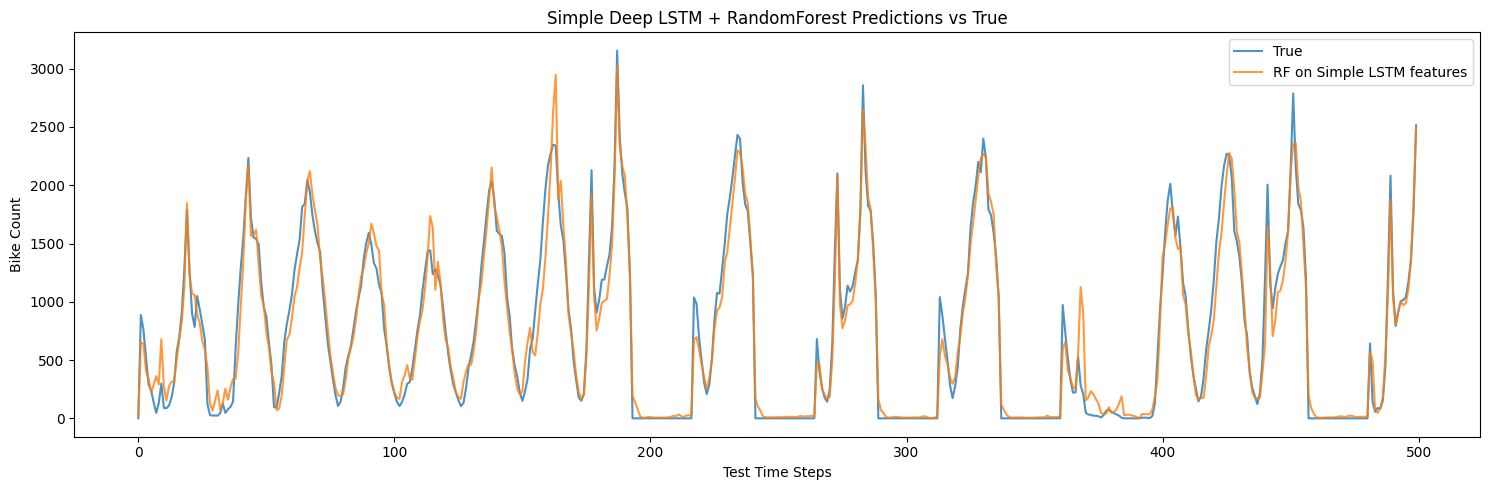

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning: convert Date to datetime, sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (same as your script) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Chronological train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences (time-based, end part as val)
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. Simple Deep LSTM Model ----------------
class SimpleDeepLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim3, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # Use last timestep output
        out = out[:, -1, :]
        out = self.dropout(out)
        output = self.fc(out)
        return output

# Create model
input_dim = n_features
model = SimpleDeepLSTM(input_dim=input_dim, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Simple Deep LSTM: input_dim={input_dim}, hidden=[256,128,64]")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Extract LSTM features for RF ----------------
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            # Extract features from final LSTM layer (last timestep)
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            feats = out[:, -1, :]  # [B, hidden_dim3=64]
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

# Inverse-scale targets back to original scale
train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# ---------------- 11. RandomForest on LSTM features ----------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# ---------------- 12. Evaluation on TEST set (original scale) ----------------
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Simple Deep LSTM features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 13. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on Simple LSTM features', alpha=0.8)
plt.legend()
plt.title('Simple Deep LSTM + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


addin more features

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

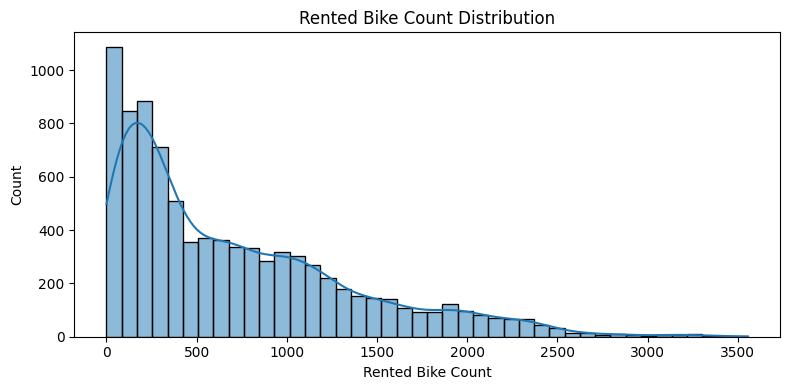

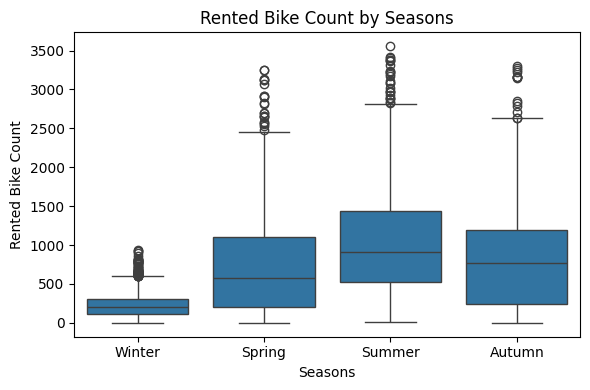

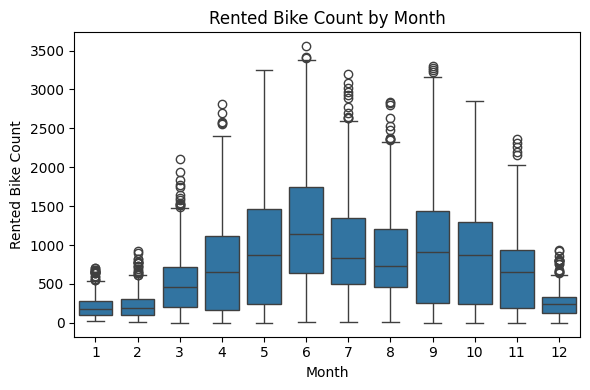

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\3212511358.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


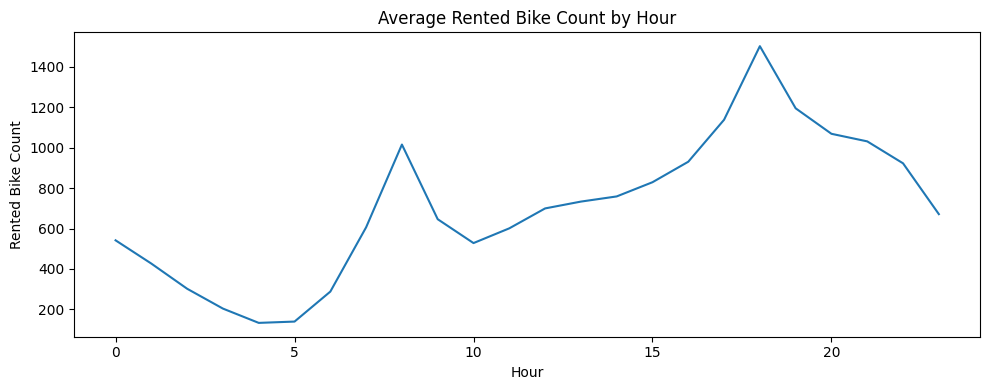

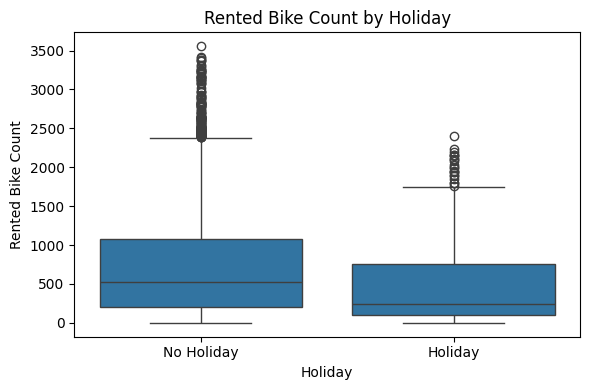

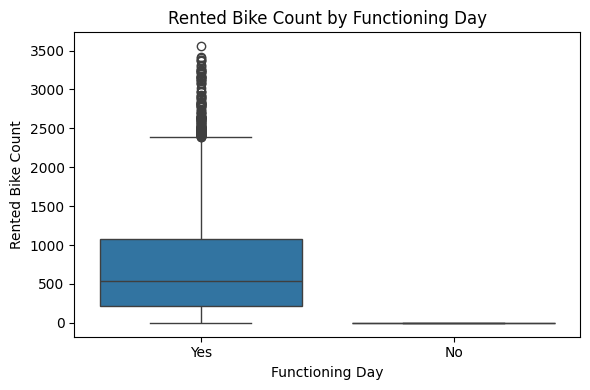

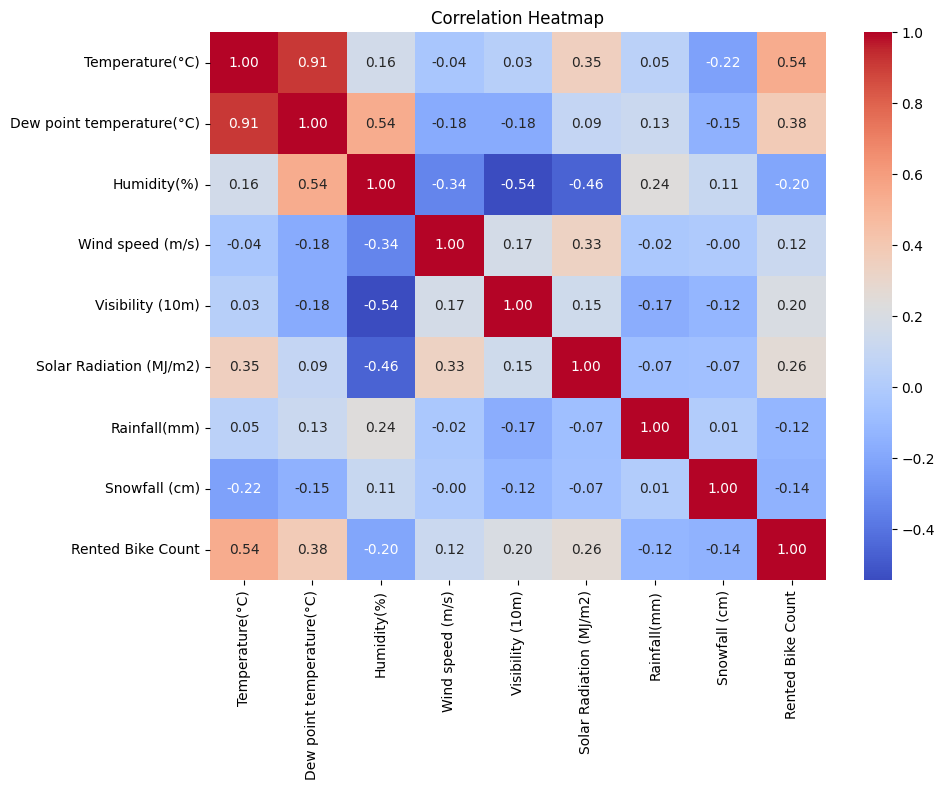

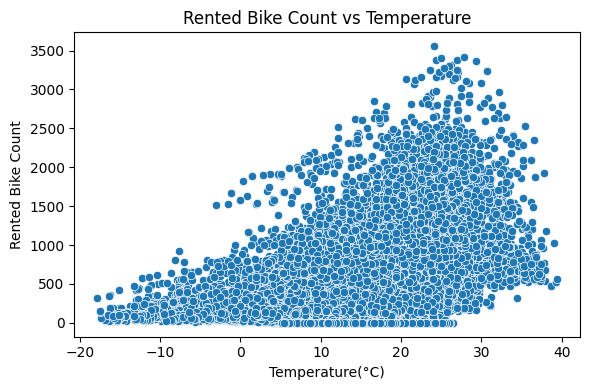

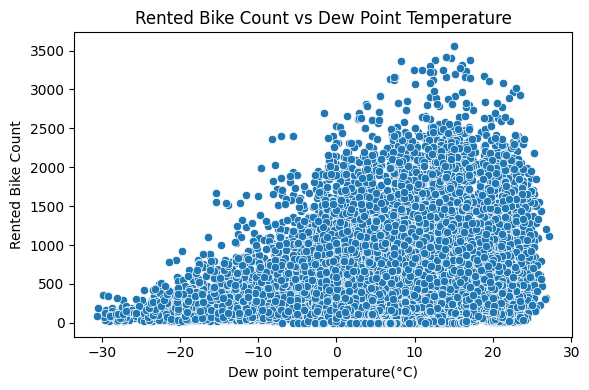

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\3212511358.py:133: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


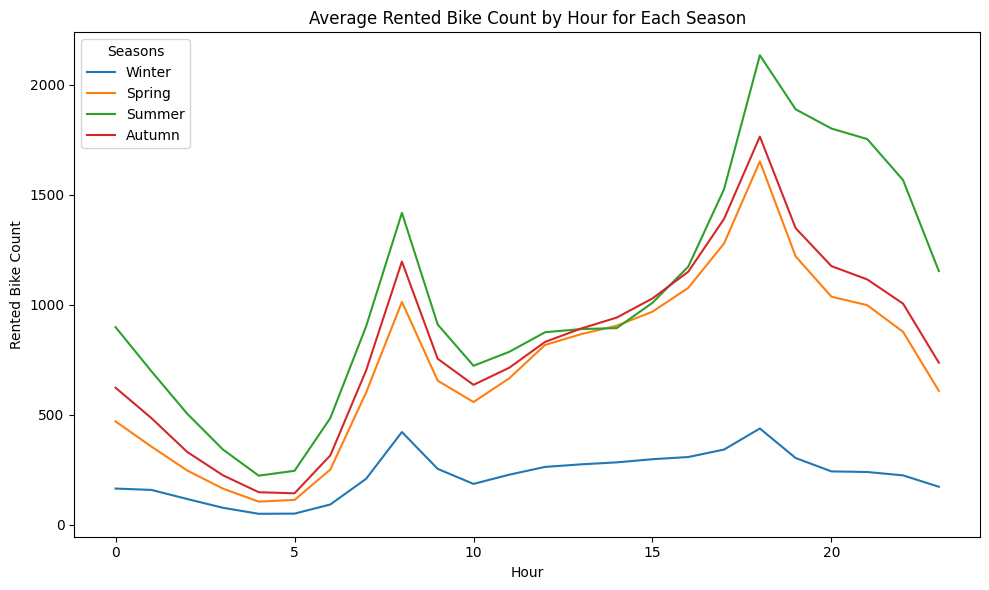

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
Simple Deep LSTM: input_dim=30, hidden=[256,128,64]


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/100: train 0.3759 | val 0.3580
Epoch 2/100: train 0.1928 | val 0.2624
Epoch 3/100: train 0.1540 | val 0.2376
Epoch 4/100: train 0.1283 | val 0.2326
Epoch 5/100: train 0.1076 | val 0.2076
Epoch 6/100: train 0.1023 | val 0.2038
Epoch 7/100: train 0.0929 | val 0.1991
Epoch 8/100: train 0.0799 | val 0.1557
Epoch 9/100: train 0.0686 | val 0.1379
Epoch 10/100: train 0.0610 | val 0.1342
Epoch 11/100: train 0.0546 | val 0.1437
Epoch 12/100: train 0.0479 | val 0.1279
Epoch 13/100: train 0.0432 | val 0.0977
Epoch 14/100: train 0.0417 | val 0.1042
Epoch 15/100: train 0.0400 | val 0.0876
Epoch 16/100: train 0.0380 | val 0.0891
Epoch 17/100: train 0.0353 | val 0.0797
Epoch 18/100: train 0.0334 | val 0.0778
Epoch 19/100: train 0.0321 | val 0.0771
Epoch 20/100: train 0.0328 | val 0.0859
Epoch 21/100: train 0.0320 | val 0.0748
Epoch 22/100: train 0.0311 | val 0.0707
Epoch 23/100: train 0.0304 | val 0.0757
Epoch 24/100: train 0.0293 | val 0.0774
Epoch 25/100: train 0.0285 | val 0.0836
Epoch 26/

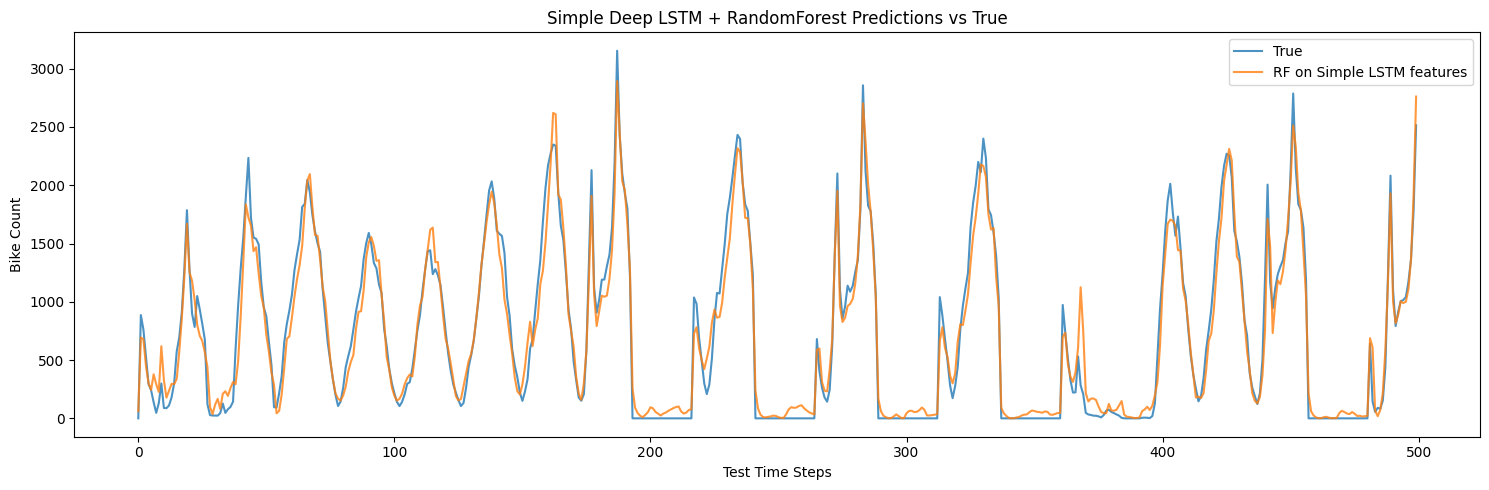

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning: convert Date to datetime, sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (same as your script) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    # Cyclical encoding FIRST (before using hour_sin)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    # Basic features
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    
    # NEW interaction features (AFTER hour_sin exists)
    df['temp_humidity_interaction'] = df['Temperature(°C)'] * df['Humidity(%)'] / 100
    df['wind_rain_interaction'] = df['Wind speed (m/s)'] * df['Rainfall(mm)']
    df['hour_temp_interaction'] = df['hour_sin'] * df['Temperature(°C)']

    # Categorical encoding
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    # Lags
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # Season dummies
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour','temp_humidity_interaction', 'wind_rain_interaction','hour_temp_interaction', 
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Chronological train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences (time-based, end part as val)
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. Simple Deep LSTM Model ----------------
class SimpleDeepLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True, dropout=dropout)
        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim3, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim3, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # Use last timestep output
        out = out[:, -1, :]
        out = self.dropout(out)
        output = self.fc(out)
        return output

# Create model
input_dim = n_features
model = SimpleDeepLSTM(input_dim=input_dim, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Simple Deep LSTM: input_dim={input_dim}, hidden=[256,128,64]")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Extract LSTM features for RF ----------------
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            # Extract features from final LSTM layer (last timestep)
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            feats = out[:, -1, :]  # [B, hidden_dim3=64]
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

# Inverse-scale targets back to original scale
train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# ---------------- 11. RandomForest on LSTM features ----------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# ---------------- 12. Evaluation on TEST set (original scale) ----------------
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Simple Deep LSTM features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 13. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on Simple LSTM features', alpha=0.8)
plt.legend()
plt.title('Simple Deep LSTM + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


RF + LSTM + Attention

Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

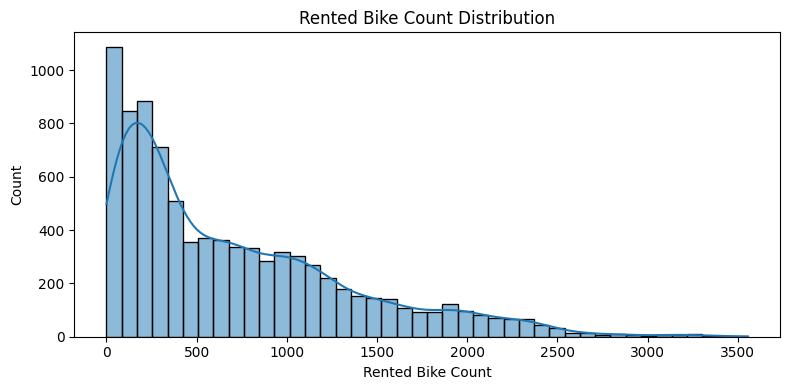

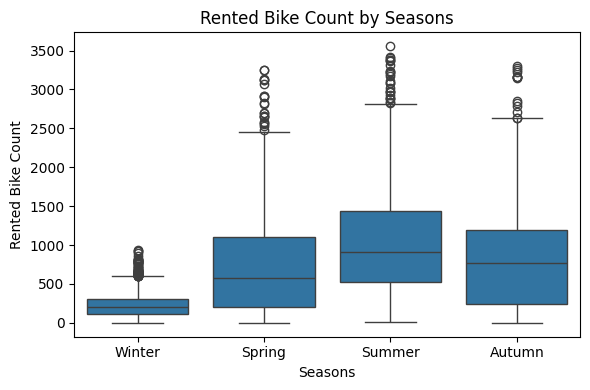

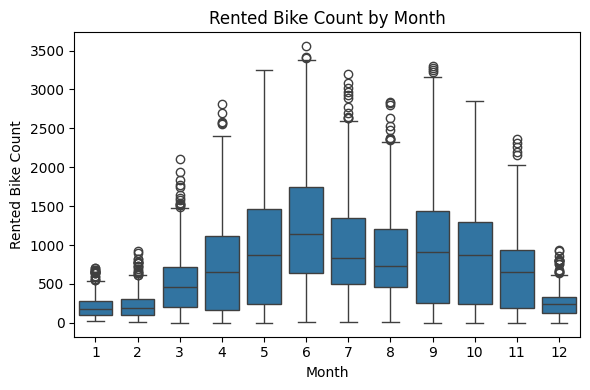

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\1993811384.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


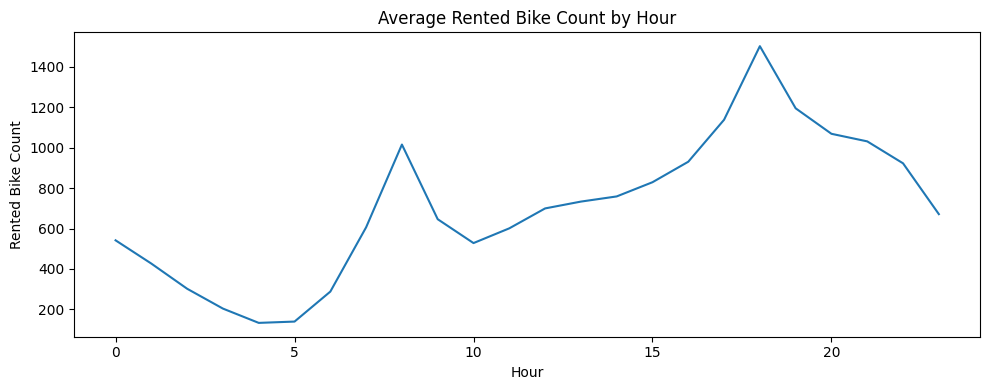

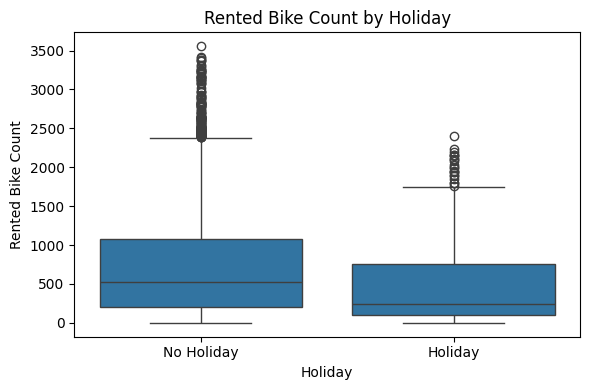

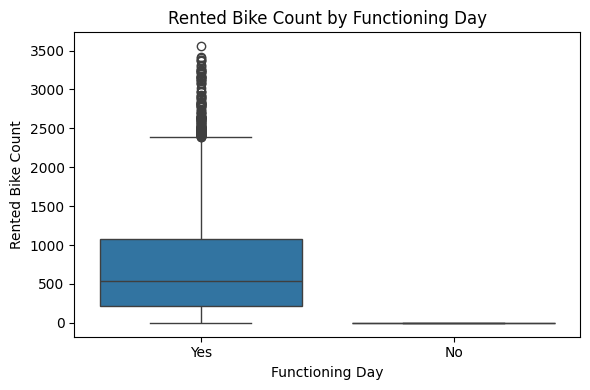

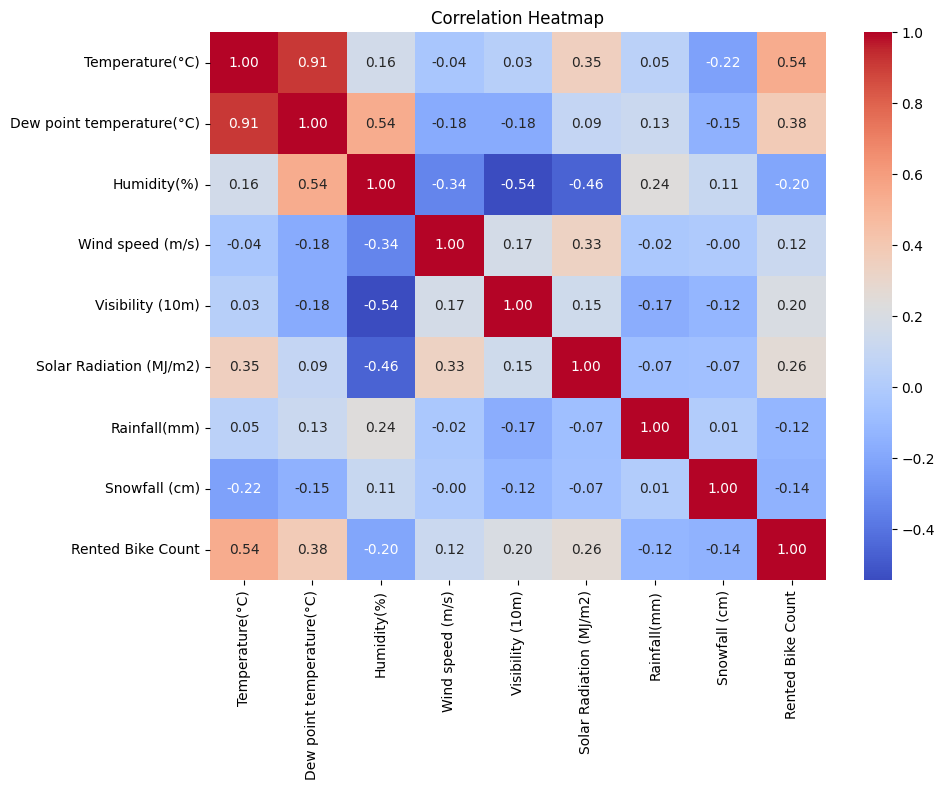

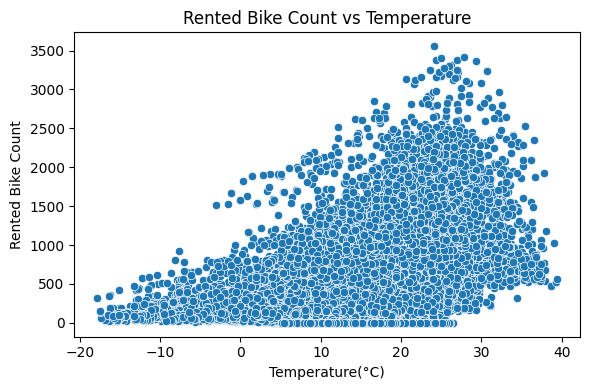

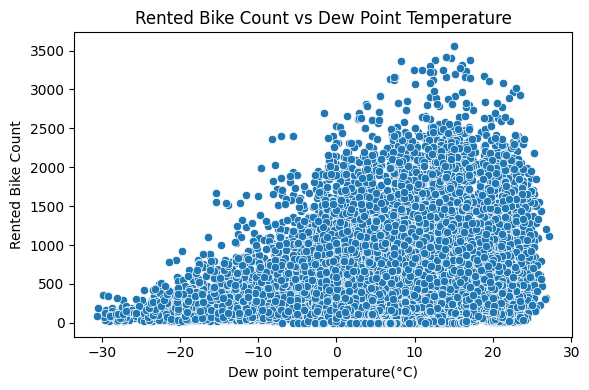

C:\Users\anavn\AppData\Local\Temp\ipykernel_2324\1993811384.py:133: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


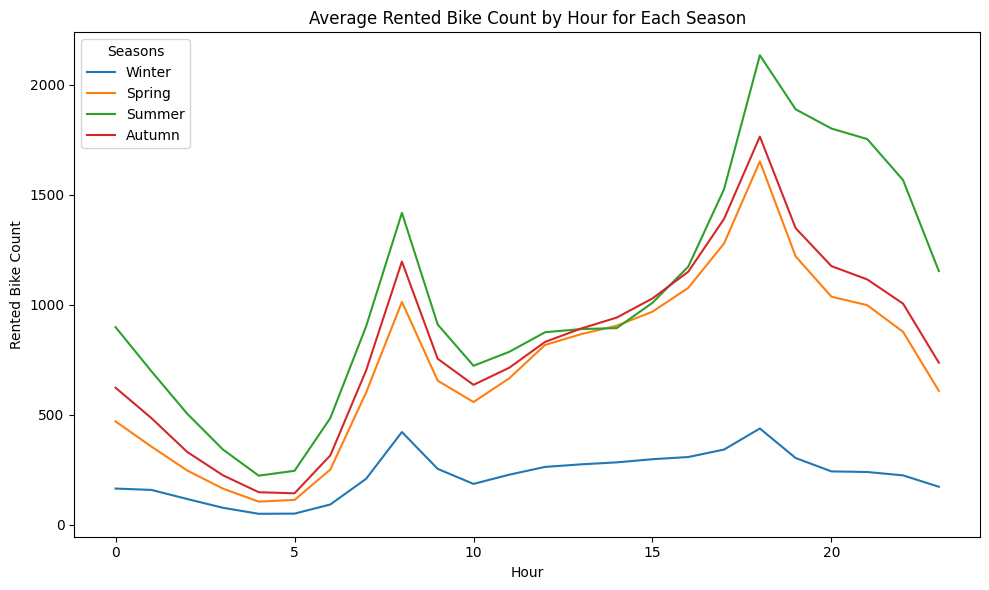

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 30), features: 30
Simple Deep LSTM: input_dim=30, hidden=[256,128,64]


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/100: train 0.4048 | val 0.4042
Epoch 2/100: train 0.1961 | val 0.2606
Epoch 3/100: train 0.1374 | val 0.1972
Epoch 4/100: train 0.1162 | val 0.2166
Epoch 5/100: train 0.0990 | val 0.1911
Epoch 6/100: train 0.0869 | val 0.1490
Epoch 7/100: train 0.0787 | val 0.1580
Epoch 8/100: train 0.0674 | val 0.1221
Epoch 9/100: train 0.0570 | val 0.1128
Epoch 10/100: train 0.0522 | val 0.0945
Epoch 11/100: train 0.0468 | val 0.0906
Epoch 12/100: train 0.0440 | val 0.0861
Epoch 13/100: train 0.0396 | val 0.0974
Epoch 14/100: train 0.0384 | val 0.0823
Epoch 15/100: train 0.0367 | val 0.0714
Epoch 16/100: train 0.0347 | val 0.0760
Epoch 17/100: train 0.0338 | val 0.0592
Epoch 18/100: train 0.0335 | val 0.1055
Epoch 19/100: train 0.0320 | val 0.0644
Epoch 20/100: train 0.0312 | val 0.0588
Epoch 21/100: train 0.0319 | val 0.0573
Epoch 22/100: train 0.0311 | val 0.0566
Epoch 23/100: train 0.0295 | val 0.0632
Epoch 24/100: train 0.0277 | val 0.0587
Epoch 25/100: train 0.0285 | val 0.0497
Epoch 26/

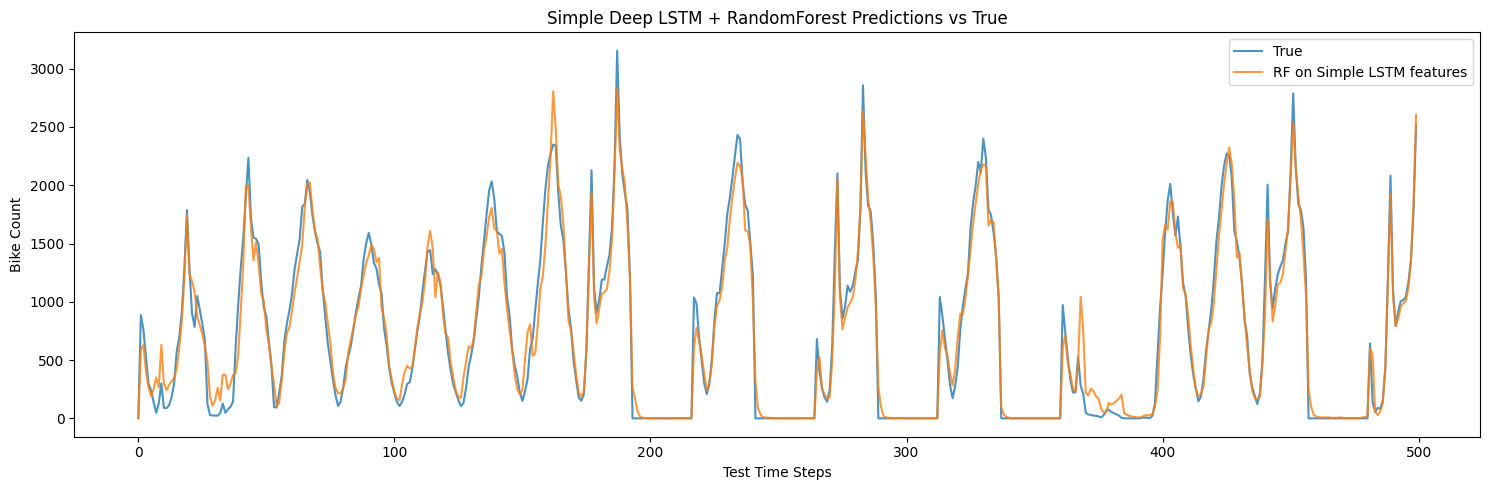

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning: convert Date to datetime, sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (same as your script) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Chronological train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences (time-based, end part as val)
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. Simple Deep LSTM Model ----------------
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [B, T, H]
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, T, 1]
        context = torch.sum(lstm_out * attn_weights, dim=1)  # [B, H]
        return self.fc(context)


# Create model
input_dim = n_features
model = SimpleDeepLSTM(input_dim=input_dim, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Simple Deep LSTM: input_dim={input_dim}, hidden=[256,128,64]")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Extract LSTM features for RF ----------------
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            # Extract features from final LSTM layer (last timestep)
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            feats = out[:, -1, :]  # [B, hidden_dim3=64]
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

# Inverse-scale targets back to original scale
train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# ---------------- 11. RandomForest on LSTM features ----------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# ---------------- 12. Evaluation on TEST set (original scale) ----------------
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Simple Deep LSTM features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 13. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on Simple LSTM features', alpha=0.8)
plt.legend()
plt.title('Simple Deep LSTM + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()


Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

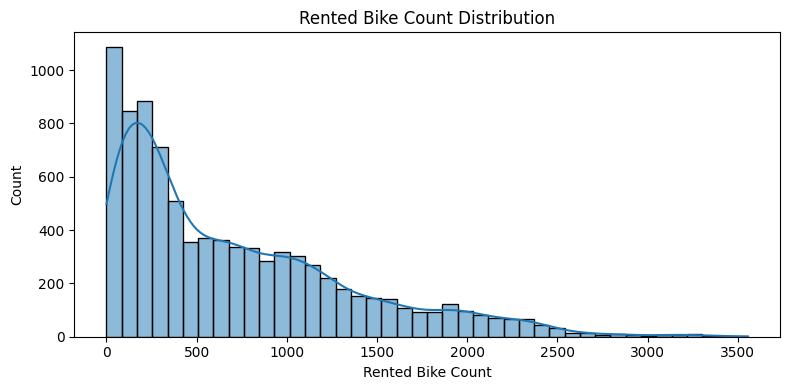

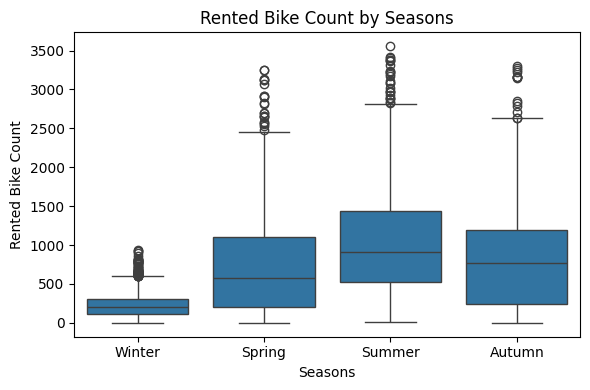

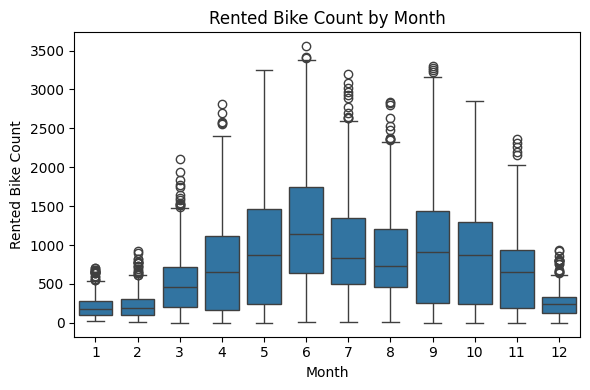

C:\Users\anavn\AppData\Local\Temp\ipykernel_12908\3012486620.py:85: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


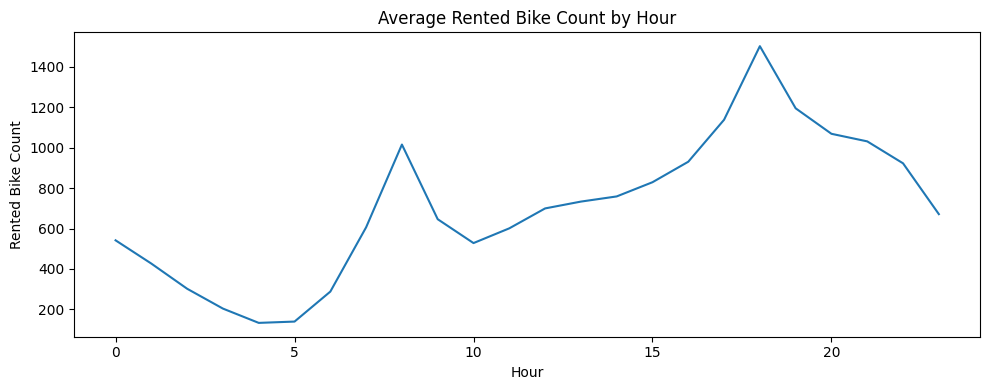

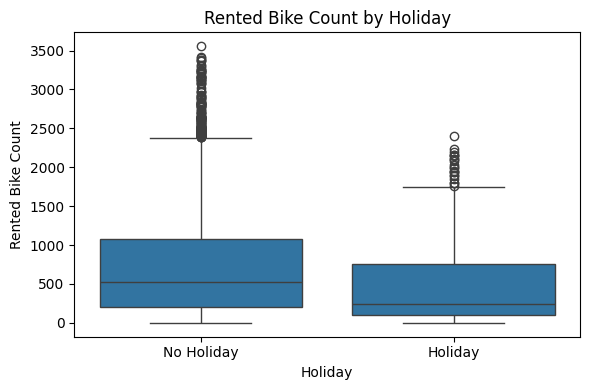

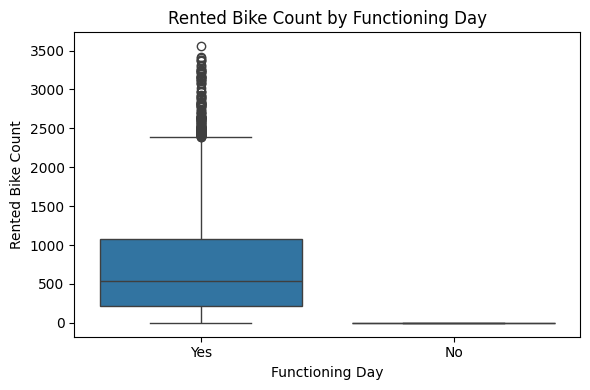

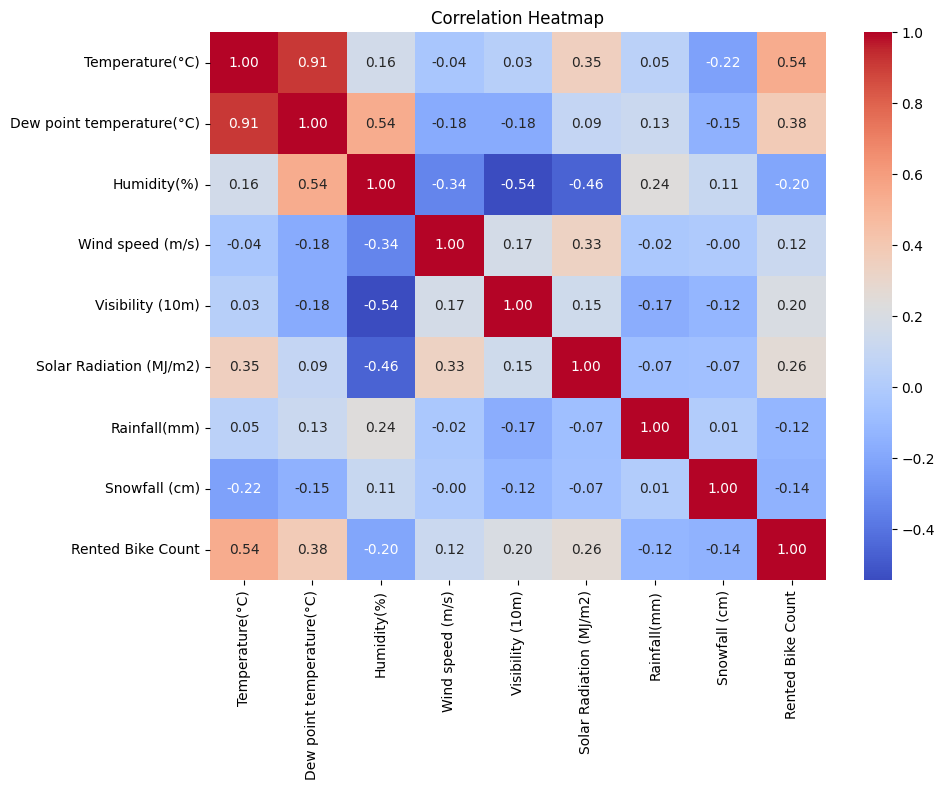

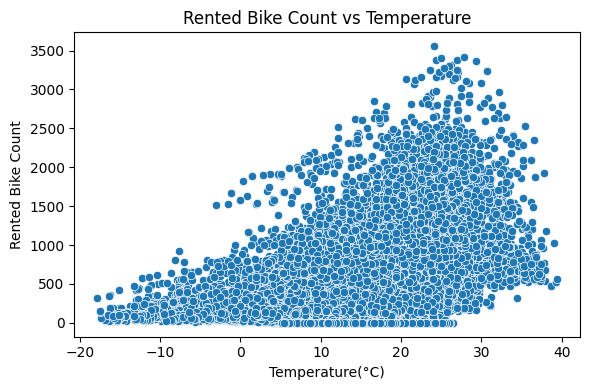

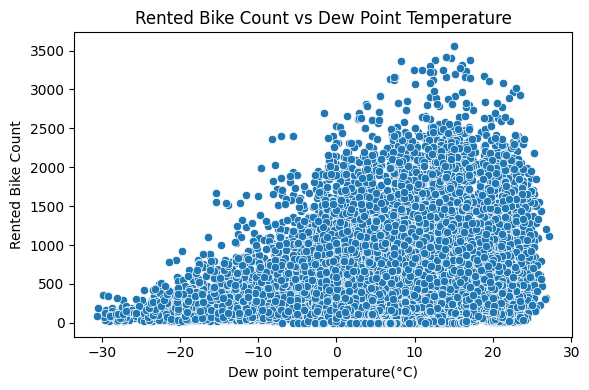

C:\Users\anavn\AppData\Local\Temp\ipykernel_12908\3012486620.py:133: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


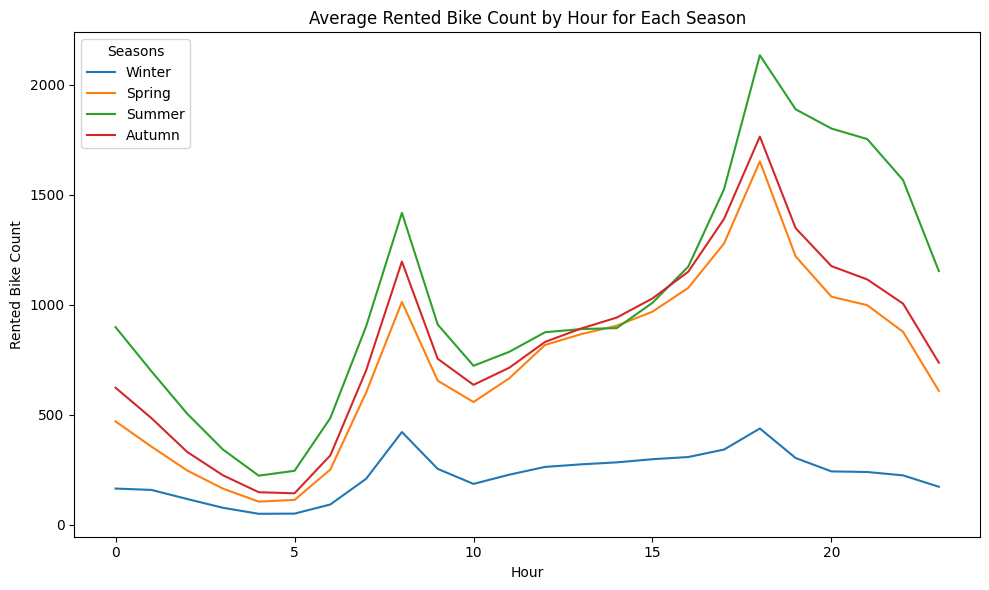

Training on 5933 train sequences, 1047 val sequences
Sequence shape: (5933, 24, 30), features: 30


NameError: name 'SimpleDeepLSTM' is not defined

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning: convert Date to datetime, sort
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (same as your script) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Month, DayOfWeek, Weekend
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Chronological train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 30
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
# def create_sequences(X, y, seq_len=24):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - seq_len):
#         X_seq.append(X[i:i + seq_len])
#         y_seq.append(y[i + seq_len - 1])
#     return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len - 1):  # Note the -1
        X_seq.append(X[i:i + seq_len])     # Up to t
        y_seq.append(y[i + seq_len])       # Predict t+1
    return np.array(X_seq), np.array(y_seq)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences (time-based, end part as val)
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. Simple Deep LSTM Model ----------------
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [B, T, H]
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # [B, T, 1]
        context = torch.sum(lstm_out * attn_weights, dim=1)  # [B, H]
        return self.fc(context)


# Create model
input_dim = n_features
model = LSTMWithAttention(input_dim=input_dim, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Simple Deep LSTM: input_dim={input_dim}, hidden=[256,128,64]")

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Extract LSTM features for RF ----------------
def extract_features(model, loader, device):
    model.eval()
    all_feats = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            # Extract features from final LSTM layer (last timestep)
            out, _ = model.lstm1(xb)
            out, _ = model.lstm2(out)
            out, _ = model.lstm3(out)
            feats = out[:, -1, :]  # [B, hidden_dim3=64]
            all_feats.append(feats.cpu().numpy())
            all_targets.append(yb.numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    return all_feats, all_targets

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_feats, train_targets_scaled = extract_features(model, train_loader_full, device)
test_feats, test_targets_scaled = extract_features(model, test_loader_full, device)

# Inverse-scale targets back to original scale
train_targets = scaler_y.inverse_transform(train_targets_scaled)
test_targets = scaler_y.inverse_transform(test_targets_scaled)

# ---------------- 11. RandomForest on LSTM features ----------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(train_feats, train_targets.ravel())
rf_preds = rf.predict(test_feats)

# ---------------- 12. Evaluation on TEST set (original scale) ----------------
y_true_all_orig = test_targets
y_pred_all_orig = rf_preds.reshape(-1, 1)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Simple Deep LSTM features + RandomForest TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 13. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='RF on Simple LSTM features', alpha=0.8)
plt.legend()
plt.title('Simple Deep LSTM + RandomForest Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()
